In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from pandas.plotting import lag_plot

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg, AR
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from prophet import Prophet

#from utils.helpers import regression_results, rmse, parser

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Importing plotly failed. Interactive plots will not work.


In [2]:
path = './shampoo_sales.csv'
df = pd.read_csv(path)
df.head()

,Month,Sales of shampoo over a three year period
0,1-Jan,266.0
1,1-Feb,145.9
2,1-Mar,183.1
3,1-Apr,119.3
4,1-May,180.3


In [3]:
df['Month'].dtype

dtype('O')

Per facilitare le analisi e rappresentazioni grafiche delle serie storiche bisogna impostare la colonna delle date
come indici del dataframe

In [4]:
df.shape

(36, 2)

Ci sono solamente 36 osservazioni, una per ogni mese per tre anni consecutivi

In [5]:
count_nan = df['Sales of shampoo over a three year period'].isnull().sum()
count_nan

0

Non ci sono valori mancanti

In [6]:
df = pd.read_csv(path,
                 parse_dates=True,
                 index_col='Month')
df.head()

,Sales of shampoo over a three year period
Month,
1-Jan,266.0
1-Feb,145.9
1-Mar,183.1
1-Apr,119.3
1-May,180.3


Ora la colonna 'Month' è l'indice del df

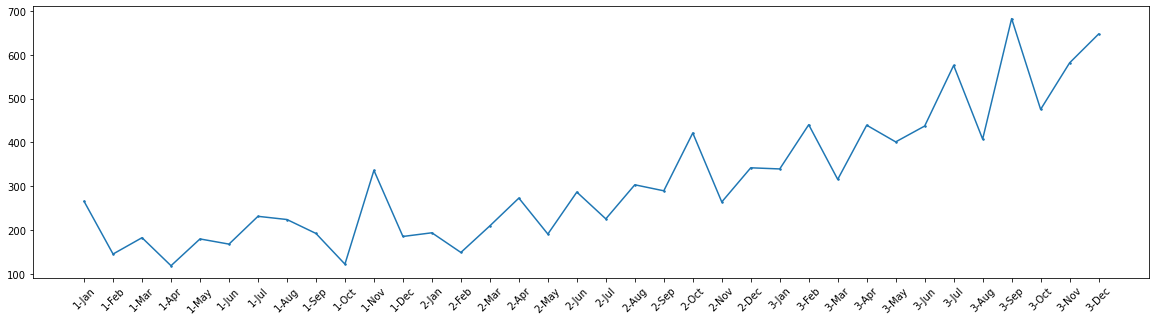

In [7]:
plt.figure(figsize=(20, 5))

plt.plot(df['Sales of shampoo over a three year period'],
         linestyle='-',
         marker='.',
         markersize=3)
plt.xticks(rotation=45)
plt.show()

Dal grafico si può notare un trend delle vendite crescente

Si desidera trasformare la colonna 'Month' in formato datetime

In [8]:
df = pd.read_csv(path)
df['Month'] = pd.to_datetime('200'+df.Month, format='%Y-%b')

Rinominiamo la colonna delle osservazioni in 'Sales'

In [9]:
df.rename({'Sales of shampoo over a three year period': 'Sales'}, axis='columns', inplace=True)
df.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


Impostiamo 'Month' come indice

In [10]:
df = df.set_index('Month')

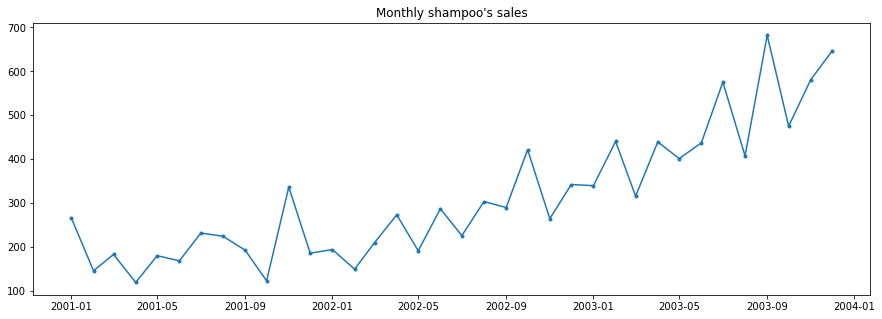

In [11]:
plt.figure(figsize=(15, 5))

plt.plot(df['Sales'],
         linestyle='-',
         marker='o',
         markersize=3)
plt.title("Monthly shampoo's sales")
plt.show()

Osserviamo le statistiche di 'Sales'

In [12]:
df['Sales'].describe()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales, dtype: float64

La deviazione standard è molto ampia rispetto alla media come si può evincere dal grafico che presenta forti picchi

In [13]:
df['Year'] = df.index.year

Creiamo la colonna 'Year' che permette di fare raggruppamenti delle osservazioni

<AxesSubplot:title={'center':"Average monthly shampoo's sales per year"}, xlabel='Year'>

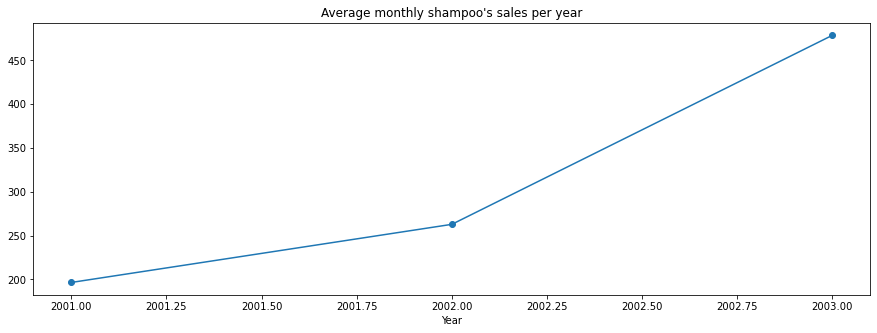

In [14]:
df.groupby('Year', sort=False)['Sales'].mean().plot(figsize=(15, 5),
                                                     marker='o',
                                                     linestyle='-',
                                                     title="Average monthly shampoo's sales per year")

<AxesSubplot:title={'center':"Total annual shampoo's sales"}, xlabel='Year'>

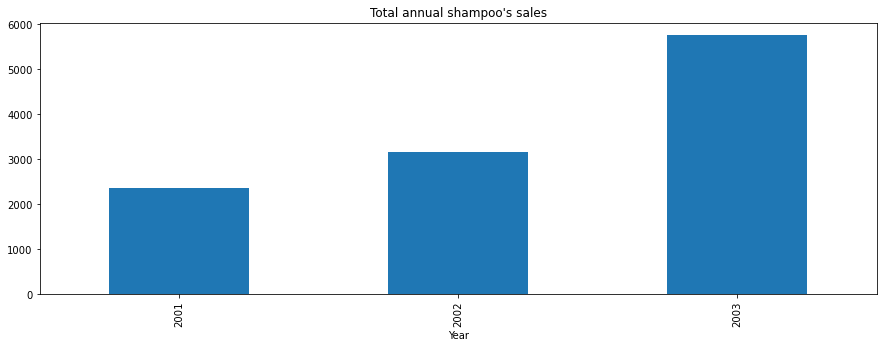

In [15]:
df.groupby('Year', sort=False)['Sales'].sum().plot.bar(figsize=(15, 5),
                                                     title="Total annual shampoo's sales")
#provare a togliere .bar

Creiamo l'istogramma per conoscere la distribuzione delle osservazioni

In [16]:
n_bins = [x*100 for x in range(0,8)]
n_bins

[0, 100, 200, 300, 400, 500, 600, 700]

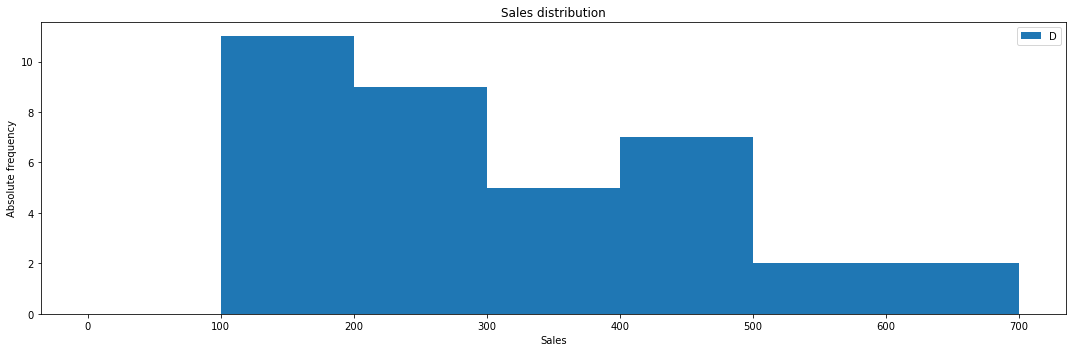

In [17]:
#n_bins=8
fig, axs = plt.subplots(1, 1,
                        figsize =(15, 5),
                        tight_layout = True)
axs.hist(df['Sales'], bins = n_bins)

plt.xlabel("Sales")
plt.ylabel("Absolute frequency")
plt.legend('Distribution')
plt.title('Sales distribution')
 
# Show plot
plt.show()

<AxesSubplot:xlabel='Sales'>

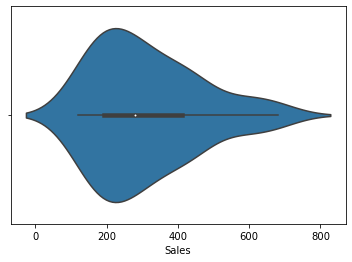

In [18]:
sns.violinplot(x=df["Sales"])

Il violinplot permette di visualizzare la distribuzione e il box plot delle vendite assieme.
Solo il 25% dei mesi osservati hanno generato vendite superiori a 410 flaconi. Quali sono?

In [19]:
df["top25%"] = np.where(df["Sales"] > 411, 1, 0)
df.tail(5)

,Sales,Year,top25%
Month,,,
2003-08-01,407.6,2003,0
2003-09-01,682.0,2003,1
2003-10-01,475.3,2003,1
2003-11-01,581.3,2003,1
2003-12-01,646.9,2003,1


Svolgiamo alcuni passaggi per visualizzare quali mesi appartengono al top 25% della distribuzione

In [20]:
sales = df['Sales'].to_numpy() 
masked = np.ma.masked_less_equal(sales, 411)

In [21]:
list_dates = df.index.strftime("%Y-%m").tolist()
indexes = [n for n in range(0, len(list_dates))] #indici dell'asse x del grafico

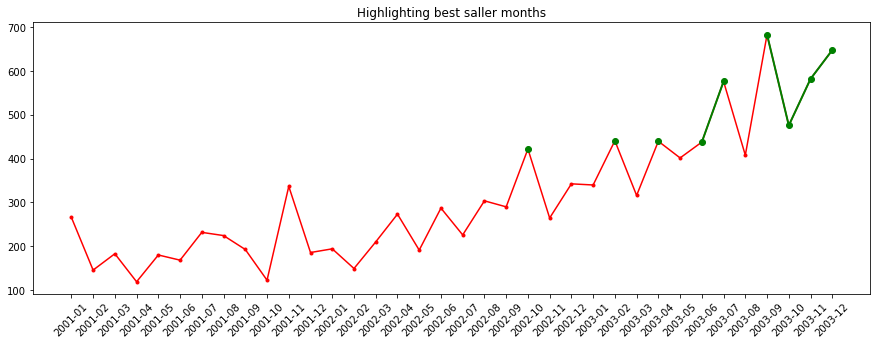

In [22]:
plt.figure(figsize=(15, 5))

plt.plot(sales,
         linestyle='-',
         marker='o',
         markersize=3,
         color='red'
         )
plt.plot(masked, 'green', linewidth=2, marker='o')
plt.xticks(indexes, list_dates, rotation=45)
plt.title('Highlighting best saller months')
plt.show()

La maggior parte dell'anno 2003 ha vendite appartenenti al top 25% della distribuzione: 8 mesi su 12

RICAMPIONAMENTO: osserviamo la distribuzione della media vendite ogni sei mesi

<AxesSubplot:title={'center':'Vendite medie mensili calcolate semestralmente'}, xlabel='Month'>

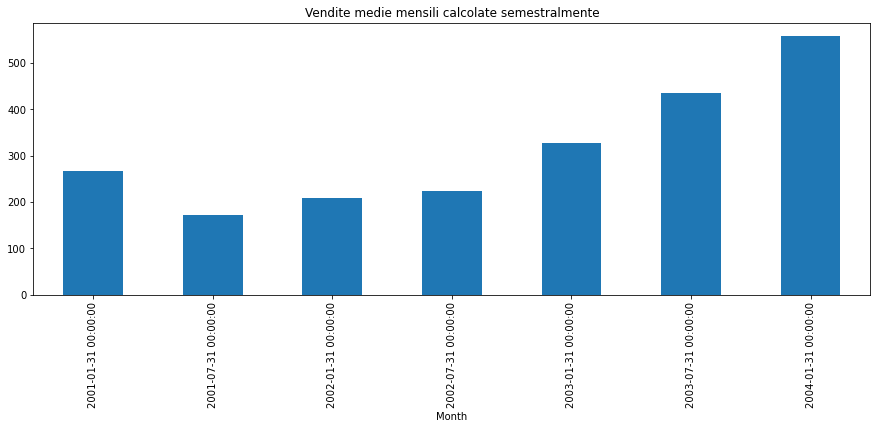

In [23]:
df["Sales"].resample("6M").mean().plot.bar(figsize=(15,5),
                            title="Vendite medie mensili calcolate semestralmente")
#o riportare a stringa o verificare opzioni plot

In [24]:
df['Month_name'] = df.index.month_name()
df.head()

,Sales,Year,top25%,Month_name
Month,,,,
2001-01-01,266.0,2001,0,January
2001-02-01,145.9,2001,0,February
2001-03-01,183.1,2001,0,March
2001-04-01,119.3,2001,0,April
2001-05-01,180.3,2001,0,May


<AxesSubplot:title={'center':"Average monthly shampoo's sales"}, xlabel='Month_name'>

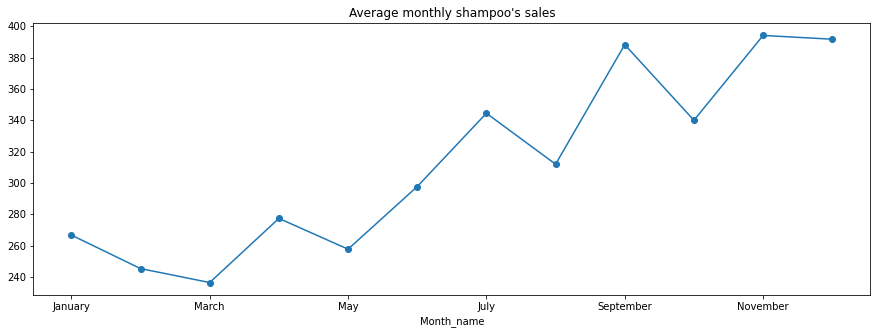

In [25]:
df.groupby('Month_name', sort=False)['Sales'].mean().plot(figsize=(15, 5),
                                                     marker='o',
                                                     linestyle='-',
                                                     title="Average monthly shampoo's sales")

VISUALIZZAZIONE DELLE STATISTICHE MOBILI

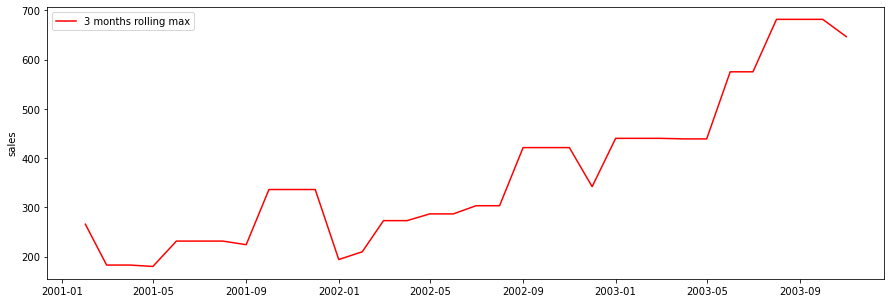

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(df['Sales'].rolling(3, center=True).max(),
         label='3 months rolling max',
         color='red')
plt.ylabel('sales')
plt.legend()
plt.show()

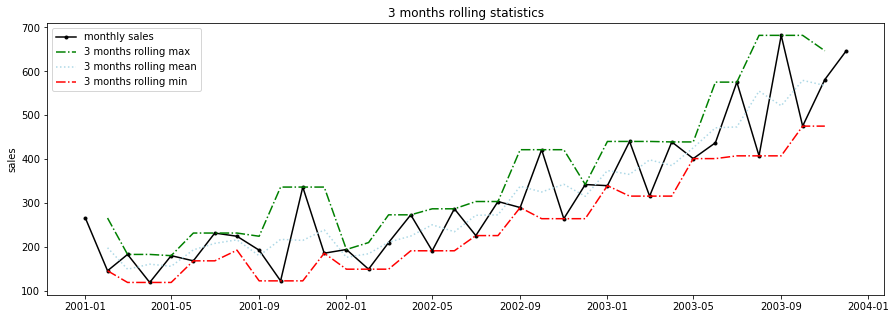

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(df['Sales'],
         linestyle='-',
         label='monthly sales',
         color='black',
         marker='o',
         markersize=3)

plt.plot(df['Sales'].rolling(3, center=True).max(),
         label='3 months rolling max',
         linestyle='-.',
         color='green')
plt.plot(df['Sales'].rolling(3, center=True).mean(),
         label='3 months rolling mean',
         linestyle=':',
         color='lightblue')
plt.plot(df['Sales'].rolling(3, center=True).min(),
         label='3 months rolling min',
         linestyle='-.',
         color='red')
plt.ylabel('sales')
plt.title('3 months rolling statistics')
plt.legend()
plt.show()

Usiamo la media mobile a 12 mesi per osservare il trend di vendita

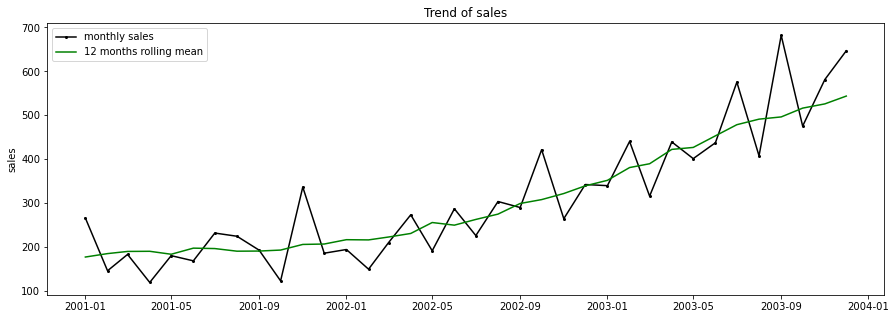

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(df['Sales'],
         linestyle='-',
         label='monthly sales',
         color='black',
         marker='o',
         markersize=2)

plt.plot(df['Sales'].rolling(12, center=True, min_periods=1).mean(),
         label='12 months rolling mean',
         color='green')
plt.ylabel('sales')
plt.legend()
plt.title('Trend of sales')
plt.show()

La media mobile a 12 mesi permette di vedere il trend crescente delle vendite di shampoo dal 2001 alla fine del 2003

In [29]:
season_dict = {
    'June':'Summer', 'July':'Summer', 'August':'Summer',
    'December':'Winter', 'January':'Winter', 'February':'Winter',
    'March':'Spring','April':'Spring','May':'Spring',
    'September':'Autumn','October':'Autumn','November':'Autumn'
}

df['Season'] = df['Month_name'].map(season_dict)

Osserviamo la media vendite mensile delle stagioni dell'anno

<AxesSubplot:title={'center':"Average seasonal shampoo's sales"}, xlabel='Season'>

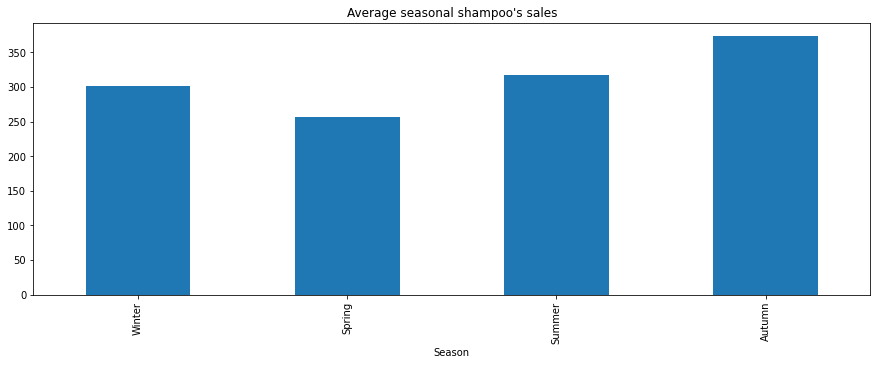

In [30]:
df.groupby('Season', sort=False)['Sales'].mean().plot.bar(figsize=(15, 5),
                                                     title="Average seasonal shampoo's sales")

La media vendite maggiore si registra in Autunno, quella minore in Primavera, l'Inverno è intorno alla media campionaria: la stagionalità è data da un aumento delle vendite nei mesi Estivi e Autunnalli seguita da una diminuzione nei mesi Invernali e Primaverili.

<AxesSubplot:title={'center':"Total seasonal shampoo's sales"}, xlabel='Season'>

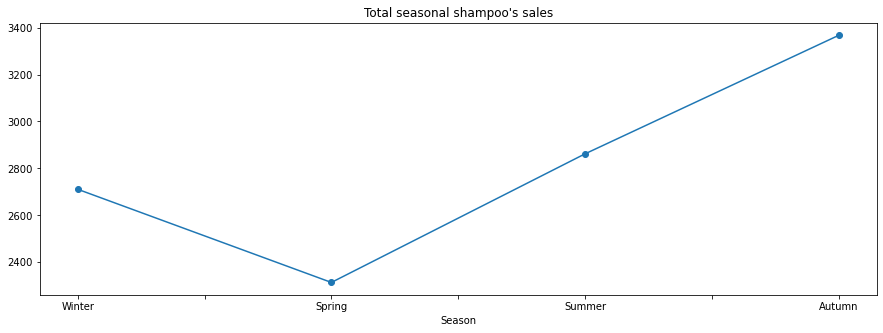

In [31]:
df.groupby('Season', sort=False)['Sales'].sum().plot(figsize=(15, 5),
                                                     marker='o',
                                                     linestyle='-',
                                                     title="Total seasonal shampoo's sales")

SEASONAL DECOMPOSITION

Level: The average value in the series.
 Trend: The increasing or decreasing value in the series.
 Seasonality: The repeating short-term cycle in the series.
 Noise: The random variation in the series.

Modello additivo:
y(t) = Level + Trend + Seasonality + Noise

In [32]:
decomposition = seasonal_decompose(df['Sales'])

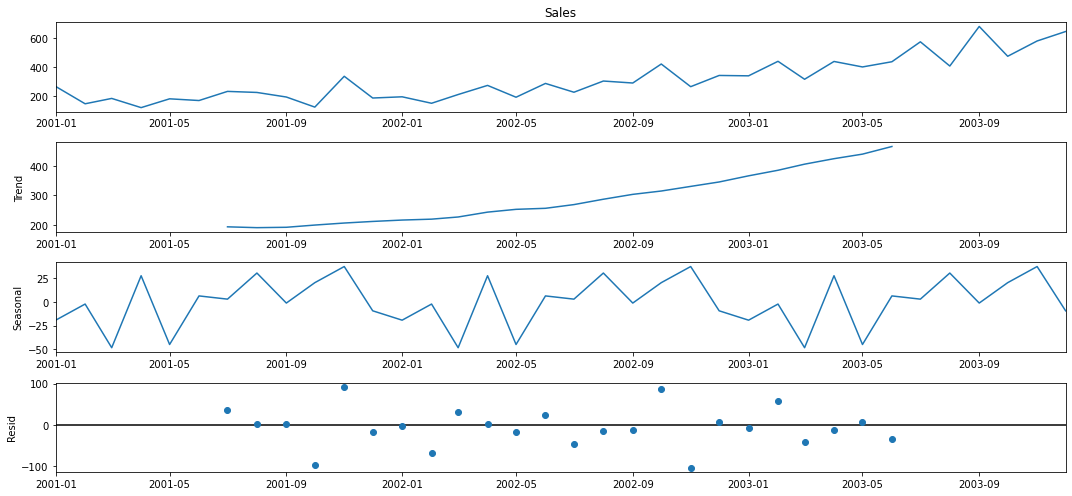

In [33]:
plt.rcParams['figure.figsize'] = (15,7)
plot = decomposition.plot() #evita plot doppi

Residuals are the time series after the trend, and seasonal components are removed.

Modello moltiplicativo
Y = Trend x Seasonality x e

In [34]:
mult_dec = seasonal_decompose(df['Sales'], model='multiplicative') #freq=1

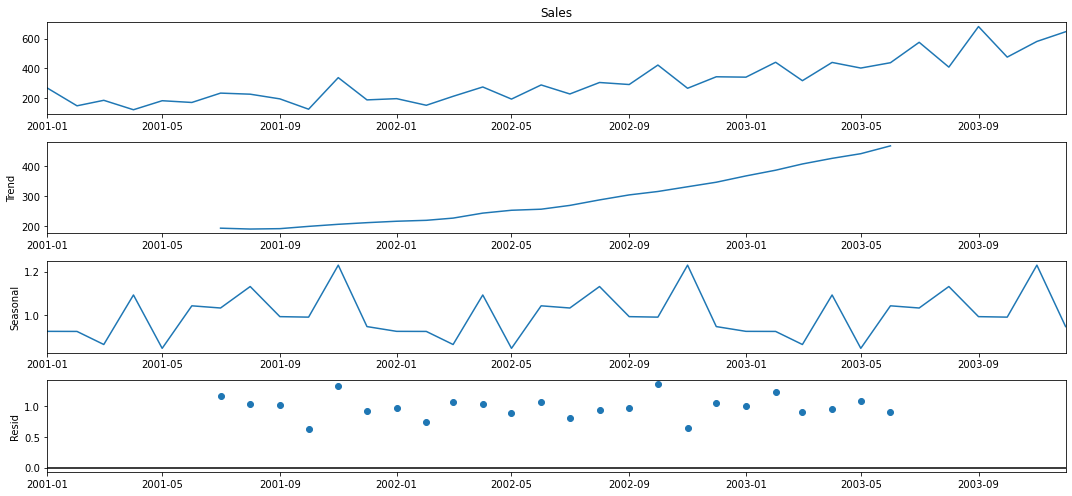

In [35]:
plt.rcParams['figure.figsize'] = (15,7)
plot = mult_dec.plot() #evita plot doppi

AUTOCORRELAZIONE

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

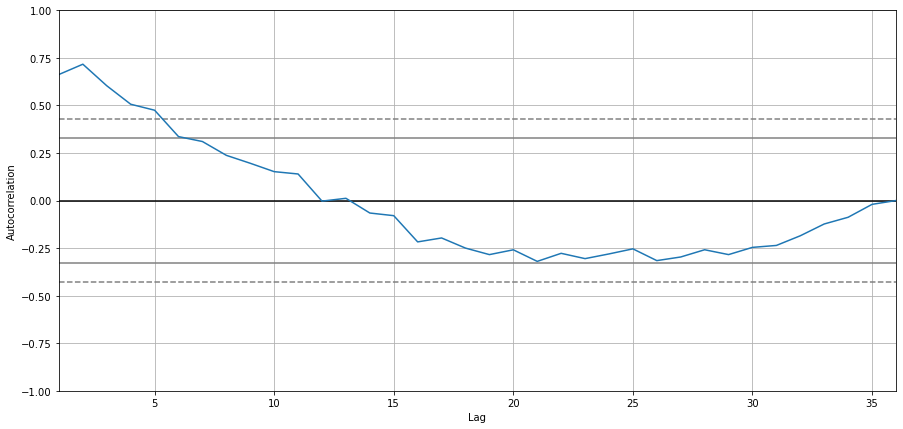

In [36]:
pd.plotting.autocorrelation_plot(df["Sales"])

"there is a positive correlation with the first 11 lags that is perhaps significant for the first 5 lags.
A good starting point for the AR parameter of the model may be 5" [pg 211]

<AxesSubplot:xlabel='Sales', ylabel='Sales'>

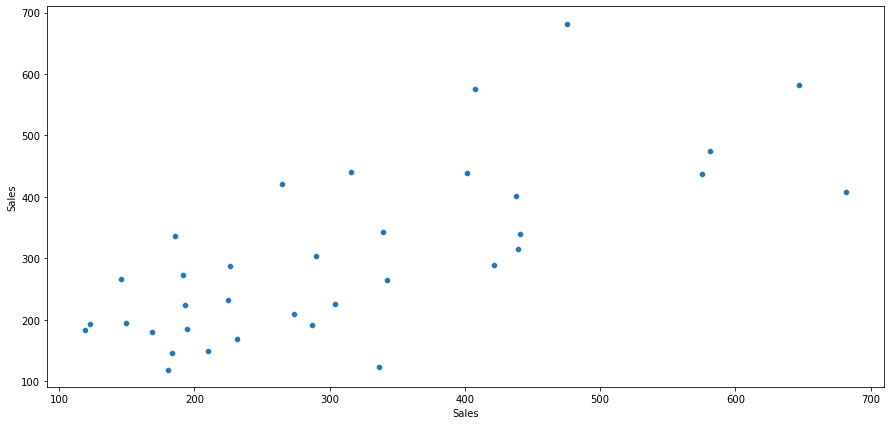

In [37]:
sns.scatterplot(x = df["Sales"], y=df["Sales"].shift(1)) #vedere dove si mette il titolo

<AxesSubplot:xlabel='Sales', ylabel='Sales'>

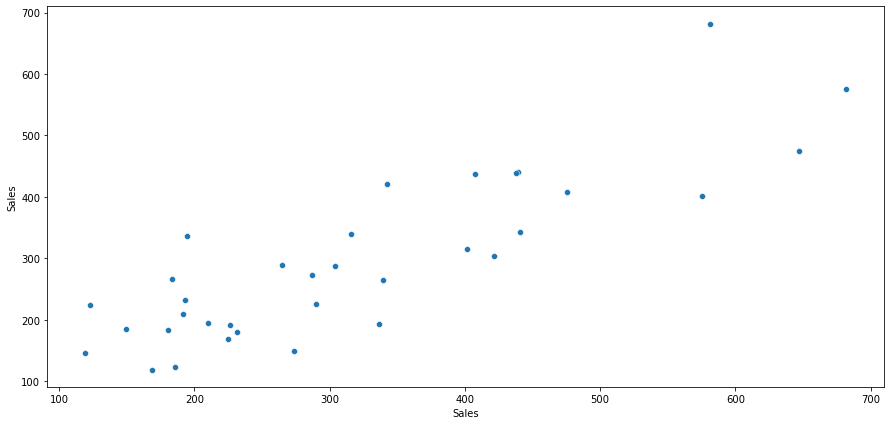

In [38]:
sns.scatterplot(x = df["Sales"], y=df["Sales"].shift(2)) #title: 'Autocorrelazione a 2 mesi'

Si ha autocorrelazione maggiore tra osservazioni a distanza di due mesi, come mostrano il grafico dell'autocorrelazione e gli scatterplot

<AxesSubplot:xlabel='Sales', ylabel='Sales'>

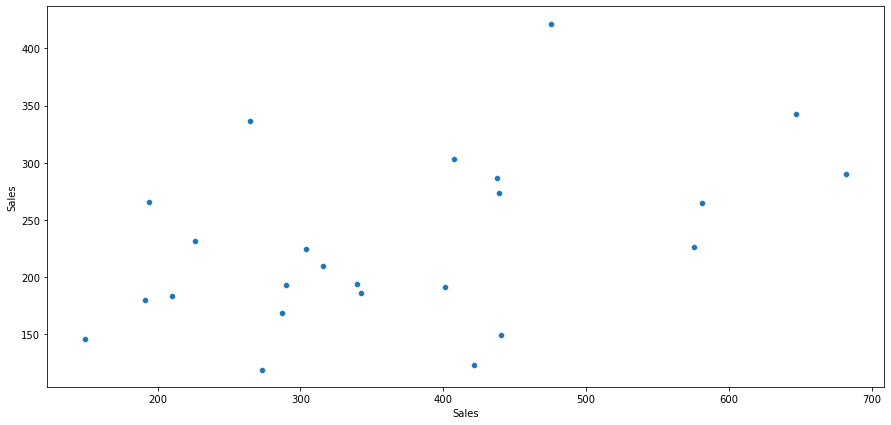

In [39]:
sns.scatterplot(x=df["Sales"], y=df["Sales"].shift(12)) #title:'Autocorrelazione a 12 mesi'

non c'è praticamente autocorrelazione tra le vendite dello stesso mese a distanza di un anno

Two diagnostic plots can be used to help choose the p and q parameters of the ARMA or ARIMA: ACF and PACF
The model is a mix of AR and MA if both the ACF and PACF trail off = affievolirsi

In [40]:
#lag_plot(df['Sales'])
#plt.show()
#it plots the temperature data (t) on the x-axis against the temperature on the previous day (t-1) on the y-axis

Text(0.5, 1.0, 'Autocorrelation with lag $\\kappa$ = 24')

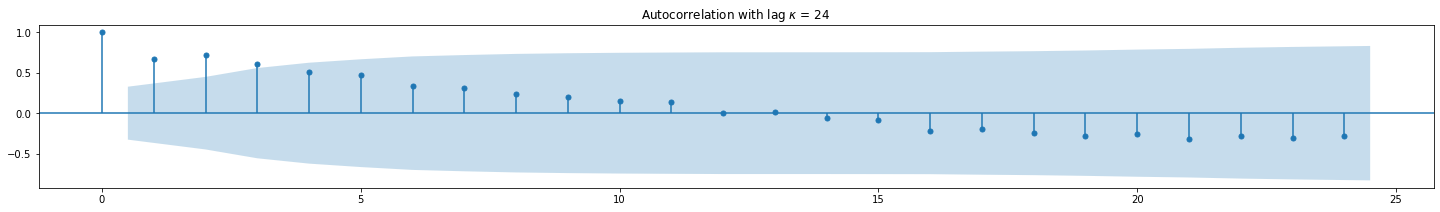

In [41]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_acf(df['Sales'], ax=ax, lags=24)
plt.title(r'Autocorrelation with lag $\kappa$ = 24')

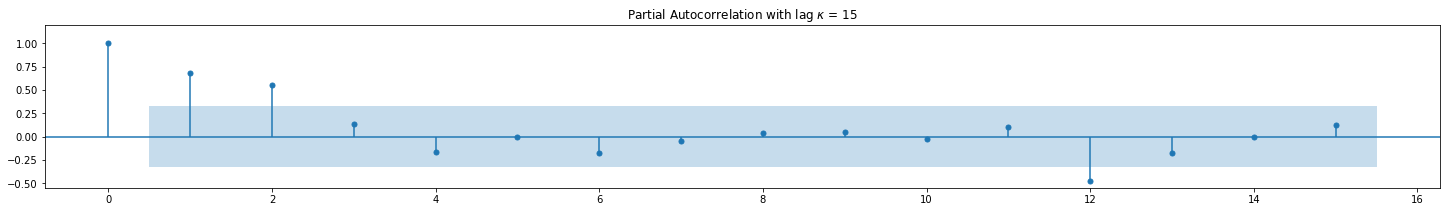

In [42]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_pacf(df['Sales'], ax=ax, lags=15)
plt.ylim(top=1.2)
plt.title(r'Partial Autocorrelation with lag $\kappa$ = 15');

"The autocorrelation for an observation and an observation at a prior time step is comprised
of both the direct correlation and indirect correlations. These indirect correlations are a linear
function of the correlation of the observation, with observations at intervening time steps. It is
these indirect correlations that the partial autocorrelation function seeks to remove" [pg 222]

Per dettagli sull'interpretazione dei grafici ACF e PACF guardare il video al link: https://www.youtube.com/watch?v=ZE_WGBe0_VU&ab_channel=LasseEngboChristiansen e pg 224 e 297 libro "Introduction to time series forecasting with Python".

Interpretazione: bisognerebbe usare un modello AR con un lag di due mesi perchè la PACF significativa si ha fino a due mesi mentre la ACF si affievolisce più gradualmente dopo 2 lag.

TEST STAZIONARIETA'

In [43]:
def adf_test(timeseries):
    """
    Takes a Pandas Series as input and calculate its ADF test values.

    Parameters
    ----------
    timeseries: Pandas Series 

    Returns
    -------
    None

    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [44]:
adf_test(df['Sales'])

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


Non si può ASSOLUTAMENTE rigettare l'ipotesi nulla sulla non stazionarietà, la serie storica NON è STAZIONARIA.
Vediamo se il test KPSS conferma tale risultato:

In [45]:
def kpss_test(timeseries):
    """
    Takes a Pandas Series as input and calculate its KPSS test values.

    Parameters
    ----------
    timeseries: Pandas Series 

    Returns
    -------
    None

    """
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='ct', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [46]:
kpss_test(df['Sales'])

Results of KPSS Test:
Test Statistic           0.240911
p-value                  0.010000
#Lags Used               3.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Possiamo rifiutare l'ipotesi nulla che la serie storica sia stazionaria. La non stazionarietà era intuibile dal grafico di Sales in cui si nota un trend crescente: "A time series with a trend is called non-stationary".

ARIMA = auto-regressive integrated moving average model

"AR: Autoregression. A model that uses the dependent relationship between an observation
and some number of lagged observations. An autoregression model is a linear regression model that uses lagged variables as input variables [194].
 I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation
from an observation at the previous time step) in order to make the time series stationary.
 MA: Moving Average. A model that uses the dependency between an observation and
residual errors from a moving average model applied to lagged observations" [pg 183] Praticamente corrisponde ad un modello AR applicato ai residui del modello AR applicato ai dati iniziali = osservazioni.
"An autoregression of the residual error time series is called a Moving Average (MA) model" [pg 200]

il modello ARIMA necessita 3 parametri: (p,d,q)
p = last significant partial autocorr, per modello AR
d = lags for differencing = integrazione I
q = highest autocorr, per modello MA

"p: The number of lag observations included in the model, also called the lag order.
 d: The number of times that the raw observations are differenced, also called the degree
of differencing.
 q: The size of the moving average window, also called the order of moving average." [pg 183]

Il modello ARIMA restituisce delle predizioni migliori quando la serie è stazionaria. Per cominciare osserviamo i risultati delle predizioni sulla serie storica originale che è NON STAZIONARIA.

In [47]:
df.loc[:,'Month_before'] = df.loc[:,'Sales'].shift()

In [48]:
df = df.dropna()

In [49]:
df.shape

(35, 6)

Usando la colonna delle differenze tra il mese precedente e quello precedente ancora la capacità predittiva aumenta perchè abbiamo eliminato il trend

Proviamo a vedere come performa il modello ARIMA direttamente su sales

In [50]:
train = df.loc[:'2002', 'Sales'].values #in base ai dati del mese prima voglio predire quelli del mese successivo
test = df.loc['2003', 'Sales'].values
history = [x for x in train]

In [51]:
predictions = list()
# walk-forward validation = di volta in volta aggiungo l'osservazione del mese successivo come dato per il training del modello
#le predizioni sono calcolate una alla volta. Questo metodo è detto anche 'rolling one-step forecast'
for i, t in enumerate(test):
    model = ARIMA(history, order=(2,1,2)) #2 come primo paramentro della tripla = p, perchè l'ultimo valore significativo
                                          #di autocorrelazione parziale si ha per un lag pari a due mesi,
                                          #2 come terzo perchè la correlaz maggiore si ha con un lag di due
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(t)
print('Predictions:', predictions)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predictions: [292.9333975364659, 336.43585177580627, 345.70391798357394, 390.3640213442112, 343.8761970292638, 420.30172579058825, 391.70505795746703, 454.21541784268214, 527.4567258513704, 512.017914153167, 646.288992033712, 618.4156362114945]


"The errors from an ideal model would resemble
white noise, that is a Gaussian distribution with a mean of zero and a symmetrical variance [...] A non-Gaussian distribution may suggest an opportunity for data pre-processing. A skew in the distribution or a non-zero mean may suggest a bias in
forecasts that may be correct.

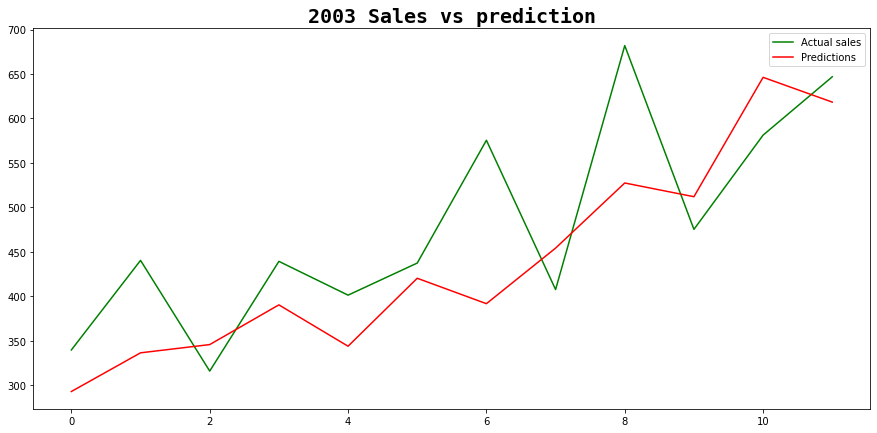

In [52]:
#plot forecasts against actual sales
plt.plot(test, color='green', label='Actual sales')
plt.plot(predictions, color='red', label="Predictions")
plt.legend()
plt.title("2003 Sales vs prediction", fontdict={"fontname":"monospace",
                                          "fontsize":20, "fontweight":"bold"})
plt.show()

In [53]:
rmse_model = round(np.sqrt(mean_squared_error(test, predictions)), 2)
rmse_model

84.7

Come si vede dal grafico e dal valore elevato (rispetto alla magnitudine delle vendite) del rmse,
il modello ARIMA non ha performato al meglio.

In [54]:
df.head() #controllo colonne presenti nel df

,Sales,Year,top25%,Month_name,Season,Month_before
Month,,,,,,
2001-02-01,145.9,2001,0,February,Winter,266.0
2001-03-01,183.1,2001,0,March,Spring,145.9
2001-04-01,119.3,2001,0,April,Spring,183.1
2001-05-01,180.3,2001,0,May,Spring,119.3
2001-06-01,168.5,2001,0,June,Summer,180.3


In [55]:
def df_loading(path: str) -> pd.DataFrame:
    """
    Returns Pandas DataFrame ready for timeseries analysis

    Parameters
    ----------
    path : string
    csv file's path


    Returns
    -------
    Pandas DataFrame
    """
    
    df = pd.read_csv(path)
    df['Month'] = pd.to_datetime('200'+df.Month, format='%Y-%b')
    df.rename({'Sales of shampoo over a three year period': 'Sales'}, axis='columns', inplace=True)
    df = df.set_index('Month')
    df.loc[:,'Delta'] = df.loc[:,'Sales'].diff() #diff(2) per sottrarre a sales di ciascun mese il valore di due mesi prima
    df['Natural log'] = np.log(df['Sales'])
    df['Box_cox'] = stats.boxcox(df['Sales'])[0]
    df = df.dropna()
    return df

In [56]:
df = df_loading('./Downloads/shampoo_sales.csv')
df.head(5)

,Sales,Delta,Natural log,Box_cox
Month,,,,
2001-02-01,145.9,-120.1,4.982921,3.972143
2001-03-01,183.1,37.2,5.210032,4.112299
2001-04-01,119.3,-63.8,4.781641,3.845383
2001-05-01,180.3,61.0,5.194622,4.102884
2001-06-01,168.5,-11.8,5.126936,4.061367


In [57]:
transf, lambd = stats.boxcox(df['Sales'])
transf

array([4.06953836, 4.21739828, 3.93611078, 4.20745462, 4.1636262 ,
       4.36797888, 4.34772296, 4.25061332, 3.95596108, 4.59994018,
       4.22717842, 4.25558752, 4.08554339, 4.30558515, 4.47137392,
       4.24593273, 4.50180561, 4.35194288, 4.53663501, 4.50804528,
       4.73675916, 4.45094088, 4.61040206, 4.60573621, 4.76293506,
       4.56113597, 4.76143714, 4.70703433, 4.75884023, 4.92138243,
       4.71643057, 5.0200969 , 4.80846247, 4.92725177, 4.98952859])

In [58]:
revers = inv_boxcox(transf, lambd)
revers

array([145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8, 122.9,
       336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. , 226. ,
       303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9, 439.3,
       401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

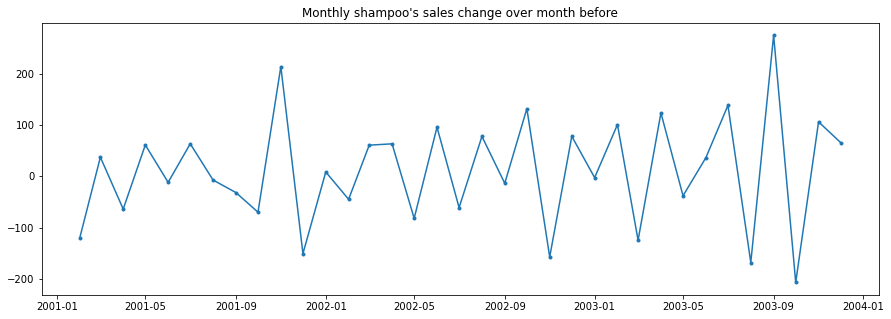

In [59]:
plt.figure(figsize=(15, 5))

plt.plot(df['Delta'],
         linestyle='-',
         marker='o',
         markersize=3)
plt.title("Monthly shampoo's sales change over month before")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

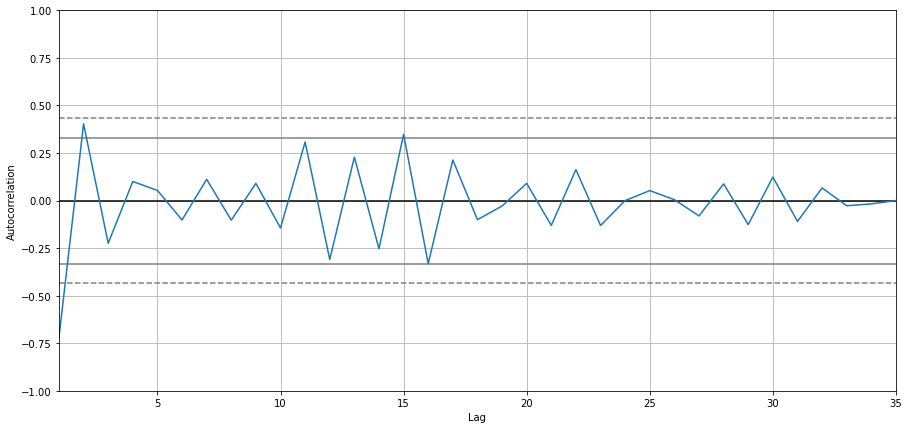

In [60]:
pd.plotting.autocorrelation_plot(df["Delta"])

Text(0.5, 1.0, 'Autocorrelation with lag $\\kappa$ = 20')

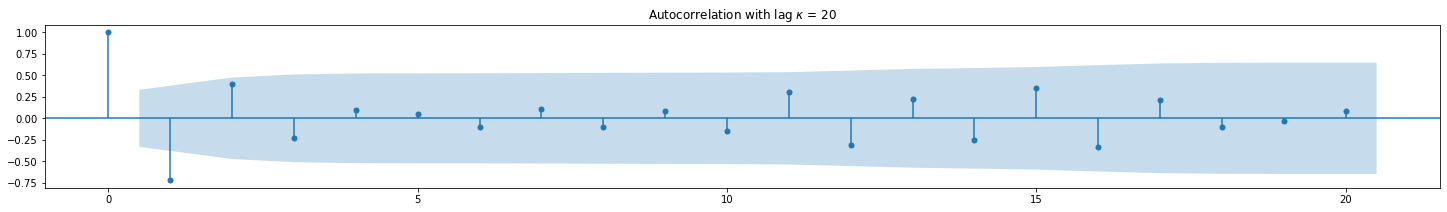

In [61]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_acf(df['Delta'], ax=ax, lags=20)
plt.title(r'Autocorrelation with lag $\kappa$ = 20')

Text(0.5, 1.0, 'Partial autocorrelation with lag $\\kappa$ = 14')

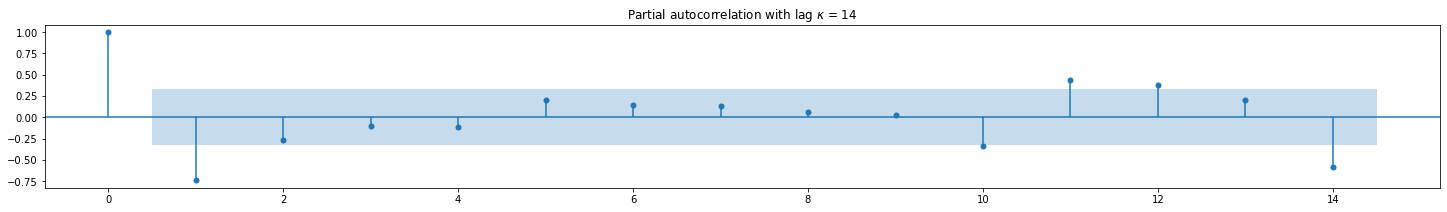

In [62]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_pacf(df['Delta'], ax=ax, lags=14)
plt.title(r'Partial autocorrelation with lag $\kappa$ = 14')

svolgiamo il test della stazionarietà per la colonna delle differenze tra t e t-1

"Should you make your time series stationary? Generally, yes. If you have clear trend and
seasonality in your time series, then model these components, remove them from observations,
then train models on the residuals".

In [63]:
adf_test(df['Delta'])

Results of Dickey-Fuller Test:
Test Statistic                -7.249074e+00
p-value                        1.799857e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


il test ADF per la stazionarietà ha dato esito negativo, quindi si può concludere che la serie storica dei delta tra un mese e l'altro è stazionaria.

In [64]:
kpss_test(df['Delta'])

Results of KPSS Test:
Test Statistic           0.039706
p-value                  0.100000
#Lags Used               2.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


il test KPSS ha dato esito positivo, si può concludere che la serie 'Delta' è stazionaria 

Text(0.5, 1.0, 'Box-cox autocorrelation with lag $\\kappa$ = 20')

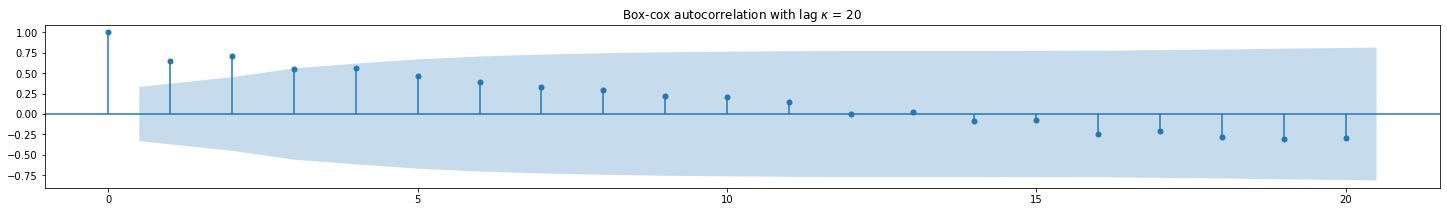

In [65]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_acf(df['Box_cox'], ax=ax, lags=20)
plt.title(r'Box-cox autocorrelation with lag $\kappa$ = 20')

Text(0.5, 1.0, 'Box-cox partial autocorrelation with lag $\\kappa$ = 14')

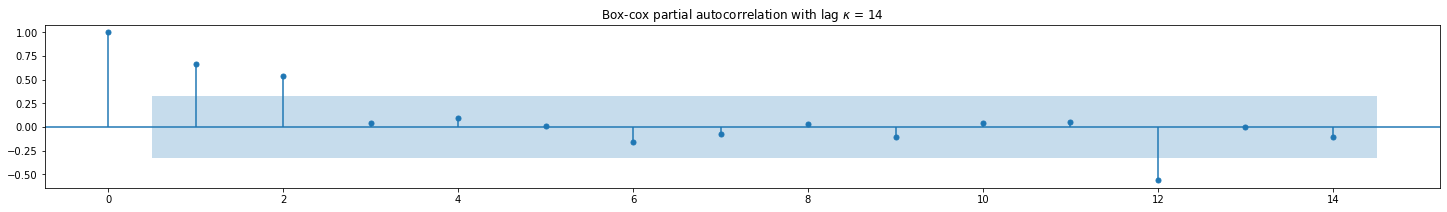

In [66]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_pacf(df['Box_cox'], ax=ax, lags=14)
plt.title(r'Box-cox partial autocorrelation with lag $\kappa$ = 14')

In [67]:
#print(type(df.loc['2003', 'Sales'])) #pandas.core.series.Series
df_predictions= df.loc['2003', 'Sales'].to_frame()
df_predictions.head()
model_performance = {}
df_performance = pd.DataFrame(columns=['Model','Rmse','R2'])
df_performance

,Model,Rmse,R2


ARMA VS ARIMA: "Assumption that the process that generated the time series can be approximated using an ARMA
model if it is stationary or an ARIMA model if it is non-stationary"

In [68]:
def arima_prediction(df: pd.DataFrame, column: str, model='ARIMA') -> None: # cambia dappertutto da typology a column
    """
    Make sales prediction for year 2003 and shows its plot and calculates rmse

    Parameters
    ----------
    df : Pandas.DataFrame
    input time series
    
    column: string
    which data to use to train the model, chose one of:
    'Sales' : takes the 'Sales' column without any transformation
    'Delta': takes the 'Delta' column as input: difference between t and t-1
    'Natural log': takes the 'Natural log' column as input
    'Box_cox': takes the 'Box_cox' column as input
    
    model: string
    which model to be trained, chose one from:
    'AR': auto-regressive
    'MA': moving average
    'ARIMA': complete model
    'SARIMAX': seasonal ARIMA
    default value='ARIMA'
    

    Returns
    -------
    None
    """
    data = column

    if data == 'Delta':
        month_bf_sales = df.loc['2002-12':'2003-11', 'Sales'].values
        

    if model =='AR':
        order = (2,1,0) #migliore per 'Delta'; anche se (1,0,0) dovrebbe essere scelto per Delta in base alla regola
                        #di guardare grafico pacf, (1,1,0) buono per Sales
    elif model =='MA':
        order=(0,1,2) #(0,0,1) per Delta, scegliere valori guardando grafico acf, (0,1,1) per Sales
    elif model =='ARIMA':
        order= (1,1,1)  #(2,1,1) oppure (2,1,2) migliore per 'Sales':
                        #(p,d,q) d è pari a uno perchè basta un periodo di diff. per raggiungere una serie stazionaria
        
    mode=model
    
    truth = df.loc['2003', 'Sales'].values
    
    train = df.loc[:'2002', data].values
    test = df.loc['2003', data].values
    history = [x for x in train]
        
    predictions = list()
    
    for i, t in enumerate(test):
        if mode == 'SARIMAX':
            model = SARIMAX(history, order=(1,1,2), seasonal_order=(1,1,2,5)) #5 = n. periodi in un ciclo con miglior risultato
        else:
            model = ARIMA(history, order=order) # in ARIMA model all coeff. are non zero
        model_fit = model.fit()
        output = model_fit.forecast() #controllare doc per parametro: dynamic=True
        yhat = output[0]
        if data =='Natural log':
            predictions.append(round(np.exp(yhat), 2))
        elif data == 'Delta':
            predictions.append(round(yhat+month_bf_sales[i], 2))
        elif data == 'Box_cox':
            inv_boxcox(transf, lambd)
            predictions.append(round(inv_boxcox(yhat, lambd), 2))
        else:
            predictions.append(round(yhat, 2))
        history.append(t)
    #print(predictions)
        
    plt.plot(truth, color='green', label='Observed')
    plt.plot(predictions, color='red', label="Prediction of sales")
    plt.title('Prediction vs Actual monthly sales of 2003')
    plt.legend()
    plt.show()
    
    residuals = [truth[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    plt.figure()
    plt.subplot(211)
    residuals.hist(ax=plt.gca())
    plt.subplot(212)
    residuals.plot(kind='kde', ax=plt.gca())
    plt.show()

    
    rmse = round(np.sqrt(mean_squared_error(truth, predictions)), 2)
    print('Root mean squared error is:', rmse)
    
    r2 = round(r2_score(truth, predictions), 2)
    print('R-squared is:', r2)
    
    
    df_predictions['{} {}'.format(data, mode)] = predictions
    print(df_predictions.head())
    
    model_performance['{} {}'.format(data, mode)] = {'rmse': rmse , 'r2': r2}
    print(model_performance)
    
    #provare anche mean absolute error()
    
    df_performance.loc[len(df_performance.index)] = ['{} {}'.format(data, mode), rmse, r2]
    print(df_performance)

"three different methods that you can use to backtest your machine learning models on time series problems.
They are:
1. Train-Test split that respect temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received".
Data l'esigua numerosità del dataset Shampoo sales, si è optato per i metodi 1 e 3.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


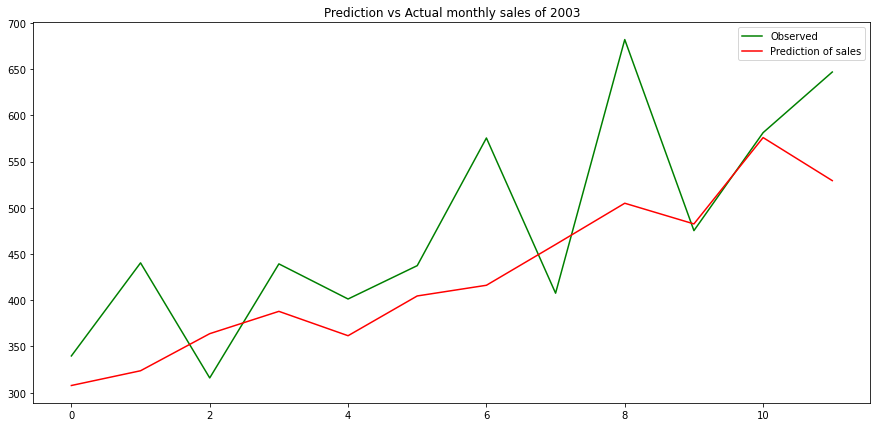

                0
count   12.000000
mean    52.004167
std     75.796198
min    -52.690000
25%      2.192500
50%     36.260000
75%    116.927500
max    177.080000


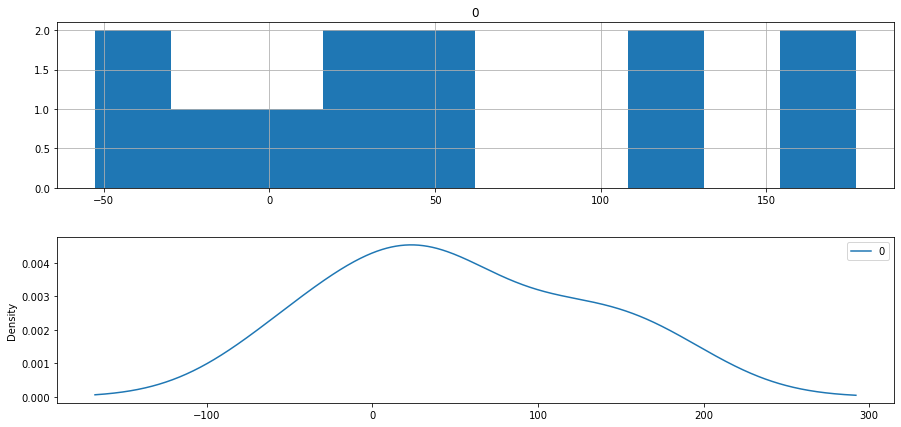

Root mean squared error is: 89.28
R-squared is: 0.37
            Sales  Natural log AR
Month                            
2003-01-01  339.7          307.71
2003-02-01  440.4          323.67
2003-03-01  315.9          363.79
2003-04-01  439.3          387.94
2003-05-01  401.3          361.58
{'Natural log AR': {'rmse': 89.28, 'r2': 0.37}}
            Model   Rmse    R2
0  Natural log AR  89.28  0.37


In [69]:
arima_prediction(df, 'Natural log', 'AR')

Come si evince dal grafico e dal rmse la predizione basata sulla trasformazione logaritmica non è stata in grado di
rispecchiare i forti picchi del 2003, sembra più indicarne il trend.

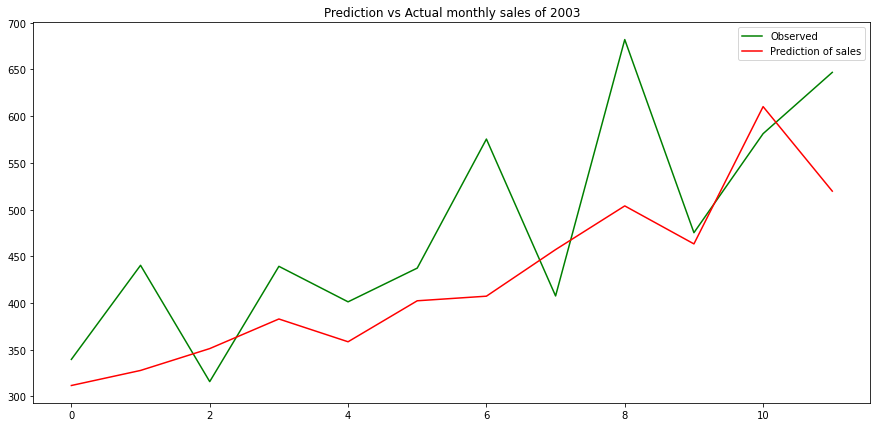

                0
count   12.000000
mean    53.833333
std     77.296684
min    -49.610000
25%      1.765000
50%     38.865000
75%    116.185000
max    178.030000


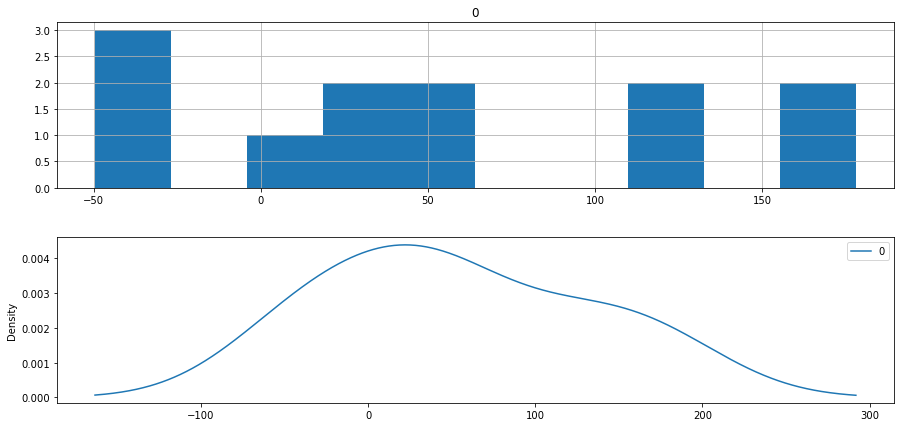

Root mean squared error is: 91.51
R-squared is: 0.34
            Sales  Natural log AR  Sales ARIMA
Month                                         
2003-01-01  339.7          307.71       311.74
2003-02-01  440.4          323.67       327.86
2003-03-01  315.9          363.79       351.25
2003-04-01  439.3          387.94       382.94
2003-05-01  401.3          361.58       358.55
{'Natural log AR': {'rmse': 89.28, 'r2': 0.37}, 'Sales ARIMA': {'rmse': 91.51, 'r2': 0.34}}
            Model   Rmse    R2
0  Natural log AR  89.28  0.37
1     Sales ARIMA  91.51  0.34


In [70]:
arima_prediction(df, 'Sales')

Anche la predizione basata sui dati di vendita non è attendibile se si è interessati ai valori effettivi e non ad un informazione sul trend.

Dato che Arima necessata di dati provenienti da distribuzione stazionaria allora vediamo come performano le predizioni
basate sui valori differenziati di un periodo (sales in t - sales in t-1)

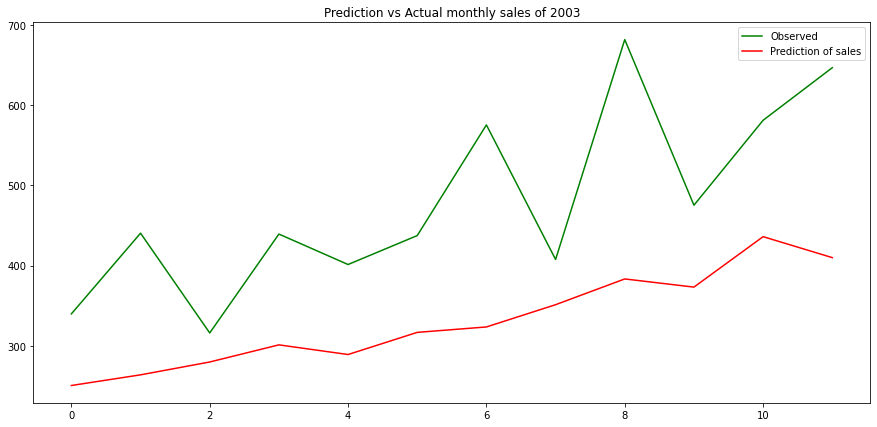

                0
count   12.000000
mean   147.123333
std     80.234556
min     36.250000
25%     98.987500
50%    129.530000
75%    191.835000
max    298.700000


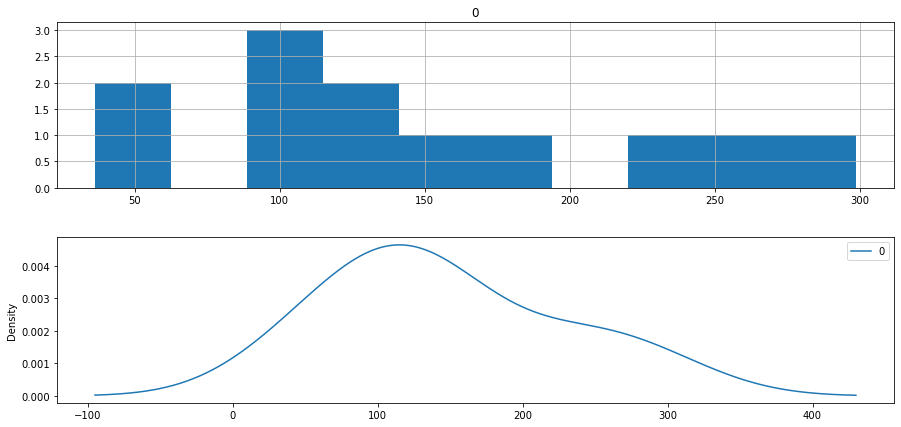

Root mean squared error is: 165.97
R-squared is: -1.19
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA
Month                                                        
2003-01-01  339.7          307.71       311.74         250.32
2003-02-01  440.4          323.67       327.86         263.62
2003-03-01  315.9          363.79       351.25         279.65
2003-04-01  439.3          387.94       382.94         301.03
2003-05-01  401.3          361.58       358.55         288.98
{'Natural log AR': {'rmse': 89.28, 'r2': 0.37}, 'Sales ARIMA': {'rmse': 91.51, 'r2': 0.34}, 'Box_cox ARIMA': {'rmse': 165.97, 'r2': -1.19}}
            Model    Rmse    R2
0  Natural log AR   89.28  0.37
1     Sales ARIMA   91.51  0.34
2   Box_cox ARIMA  165.97 -1.19


In [71]:
arima_prediction(df, 'Box_cox', 'ARIMA')

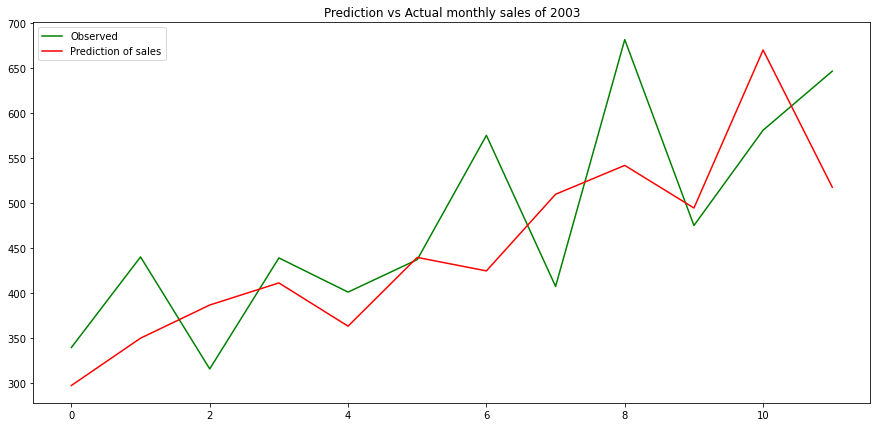

                0
count   12.000000
mean    27.761667
std     88.241612
min   -102.460000
25%    -32.367500
50%     32.830000
75%     99.980000
max    150.630000


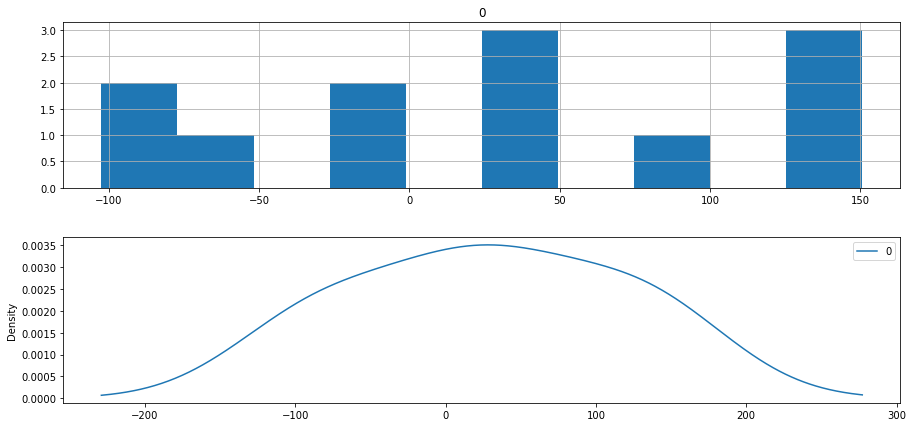

Root mean squared error is: 88.93
R-squared is: 0.37
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA  Delta ARIMA
Month                                                                     
2003-01-01  339.7          307.71       311.74         250.32       297.48
2003-02-01  440.4          323.67       327.86         263.62       350.09
2003-03-01  315.9          363.79       351.25         279.65       386.93
2003-04-01  439.3          387.94       382.94         301.03       411.50
2003-05-01  401.3          361.58       358.55         288.98       363.44
{'Natural log AR': {'rmse': 89.28, 'r2': 0.37}, 'Sales ARIMA': {'rmse': 91.51, 'r2': 0.34}, 'Box_cox ARIMA': {'rmse': 165.97, 'r2': -1.19}, 'Delta ARIMA': {'rmse': 88.93, 'r2': 0.37}}
            Model    Rmse    R2
0  Natural log AR   89.28  0.37
1     Sales ARIMA   91.51  0.34
2   Box_cox ARIMA  165.97 -1.19
3     Delta ARIMA   88.93  0.37


In [72]:
arima_prediction(df,'Delta')

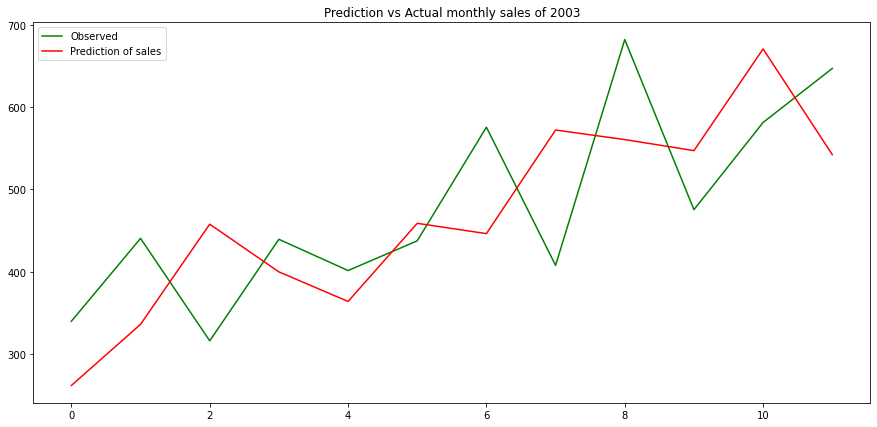

                0
count   12.000000
mean    10.556667
std    105.243612
min   -164.480000
25%    -76.132500
50%     38.570000
75%    104.525000
max    129.310000


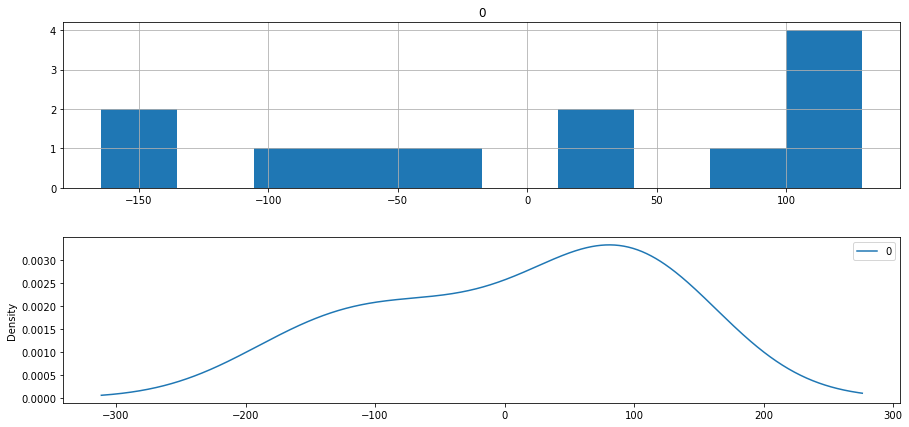

Root mean squared error is: 101.31
R-squared is: 0.18
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA  Delta ARIMA  \
Month                                                                        
2003-01-01  339.7          307.71       311.74         250.32       297.48   
2003-02-01  440.4          323.67       327.86         263.62       350.09   
2003-03-01  315.9          363.79       351.25         279.65       386.93   
2003-04-01  439.3          387.94       382.94         301.03       411.50   
2003-05-01  401.3          361.58       358.55         288.98       363.44   

            Delta AR  
Month                 
2003-01-01    261.61  
2003-02-01    335.95  
2003-03-01    457.64  
2003-04-01    399.70  
2003-05-01    363.76  
{'Natural log AR': {'rmse': 89.28, 'r2': 0.37}, 'Sales ARIMA': {'rmse': 91.51, 'r2': 0.34}, 'Box_cox ARIMA': {'rmse': 165.97, 'r2': -1.19}, 'Delta ARIMA': {'rmse': 88.93, 'r2': 0.37}, 'Delta AR': {'rmse': 101.31, 'r2': 0.18}}
            

In [73]:
arima_prediction(df,'Delta','AR')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


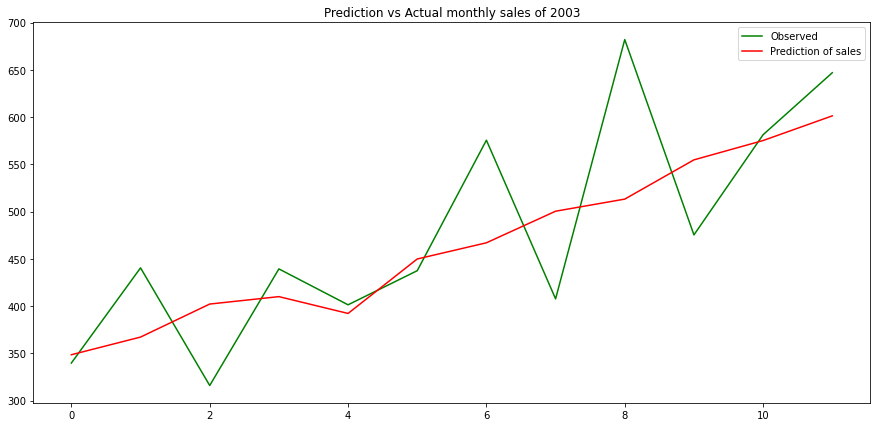

                0
count   12.000000
mean    13.449167
std     79.267955
min    -92.750000
25%    -29.150000
50%      7.640000
75%     52.540000
max    168.830000


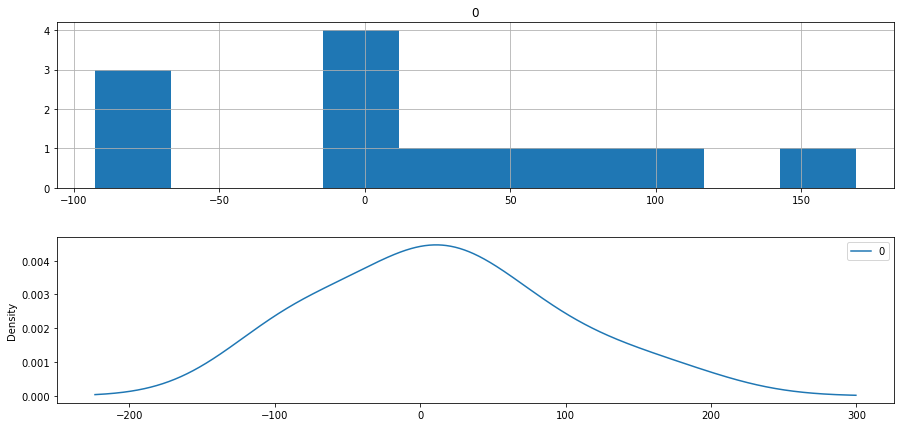

Root mean squared error is: 77.08
R-squared is: 0.53
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA  Delta ARIMA  \
Month                                                                        
2003-01-01  339.7          307.71       311.74         250.32       297.48   
2003-02-01  440.4          323.67       327.86         263.62       350.09   
2003-03-01  315.9          363.79       351.25         279.65       386.93   
2003-04-01  439.3          387.94       382.94         301.03       411.50   
2003-05-01  401.3          361.58       358.55         288.98       363.44   

            Delta AR  Delta MA  
Month                           
2003-01-01    261.61    348.46  
2003-02-01    335.95    367.16  
2003-03-01    457.64    402.10  
2003-04-01    399.70    409.96  
2003-05-01    363.76    392.16  
{'Natural log AR': {'rmse': 89.28, 'r2': 0.37}, 'Sales ARIMA': {'rmse': 91.51, 'r2': 0.34}, 'Box_cox ARIMA': {'rmse': 165.97, 'r2': -1.19}, 'Delta ARIMA': {'rmse': 88.93

In [74]:
arima_prediction(df,'Delta', 'MA')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\si

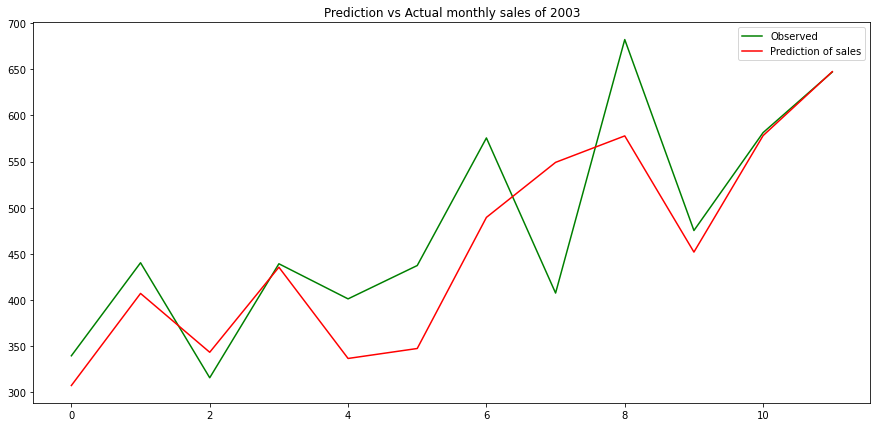

                0
count   12.000000
mean    22.570000
std     65.968331
min   -141.480000
25%      2.342500
50%     27.765000
75%     69.880000
max    104.270000


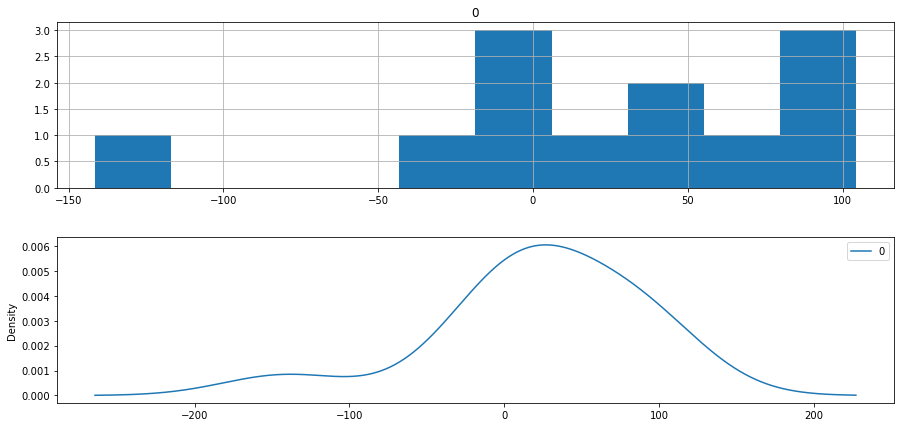

Root mean squared error is: 67.07
R-squared is: 0.64
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA  Delta ARIMA  \
Month                                                                        
2003-01-01  339.7          307.71       311.74         250.32       297.48   
2003-02-01  440.4          323.67       327.86         263.62       350.09   
2003-03-01  315.9          363.79       351.25         279.65       386.93   
2003-04-01  439.3          387.94       382.94         301.03       411.50   
2003-05-01  401.3          361.58       358.55         288.98       363.44   

            Delta AR  Delta MA  Sales SARIMAX  
Month                                          
2003-01-01    261.61    348.46         307.52  
2003-02-01    335.95    367.16         407.19  
2003-03-01    457.64    402.10         343.51  
2003-04-01    399.70    409.96         435.57  
2003-05-01    363.76    392.16         336.79  
{'Natural log AR': {'rmse': 89.28, 'r2': 0.37}, 'Sales ARIMA': {

In [75]:
arima_prediction(df, 'Sales', 'SARIMAX')

Come mostrano grafico e rmse le predizioni basate sui dati differenziati sono leggermente migliori rispetto agli altri due casi

EXPONENTIAL SMOOTHING

In [76]:
def exp_smooth_prediction(df: pd.DataFrame) -> None:
    """
    Make sales prediction for year 2003 and shows its plot and calculates rmse

    Parameters
    ----------
    df : Pandas.DataFrame
    input time series: the 'Delta' column is mandatory


    Returns
    -------
    None
    """
    train = df.loc[:'2002', "Delta"].values
    test = df.loc['2003', "Delta"].values
    
    month_bf_sales = df.loc['2002-12':'2003-11', 'Sales'].values
    sales_2003 = df.loc['2003', 'Sales'].values
    
    history = [x for x in train]
    predictions = list()
    for i, t in enumerate(test):
        #model = ExponentialSmoothing(history, seasonal_periods=5, trend='add', seasonal='add')
        model = ExponentialSmoothing(history)
        model_fit = model.fit(smoothing_level=0.20)
        yhat = model_fit.predict()[0]

        predictions.append(round(yhat+month_bf_sales[i], 2))
        history.append(t)
    
    plt.plot(predictions, label='Predictions')
    plt.plot(sales_2003, label='Sales')
    plt.title('Predizione con Exponential Smoothing model')
    plt.legend()
    plt.show()
    
    rmse = round(np.sqrt(mean_squared_error(sales_2003, predictions)), 2)
    print('Root mean squared error is:', rmse)
    
    r2 = round(r2_score(sales_2003, predictions), 2)
    print('R-squared is:', r2)
    
    df_predictions['Exp smooth'] = predictions
    print(df_predictions.head())
    
    model_performance['Exp smooth'] = {'rmse': rmse , 'r2': r2}
    print(model_performance)
    
    df_performance.loc[len(df_performance.index)] = ['Exp smooth', rmse, r2]
    print(df_performance)

In [77]:
train = df.loc[:'2002', "Delta"].values
test = df.loc['2003', "Delta"].values

seasonal_periods=12   #quanti periodi ci sono in un ciclo completo?

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, seasonal='add').fit()
pred = es.predict(start=0, end=11) #si desidera predire 12 valori

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


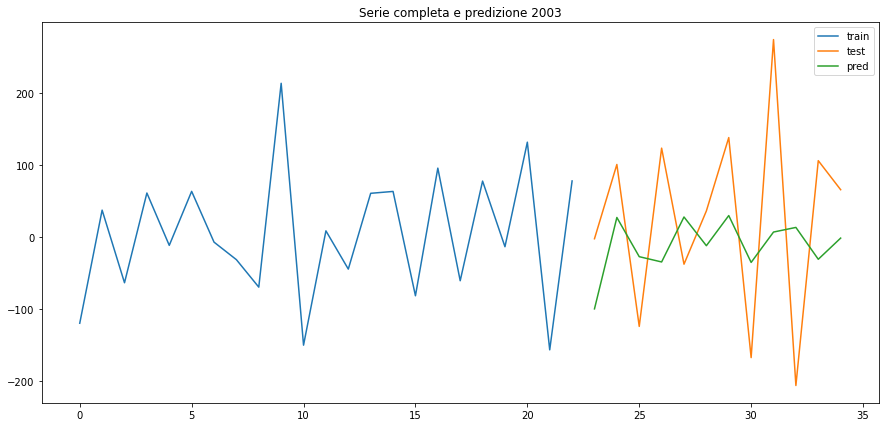

In [78]:
plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
#provare anche codice pg 163 file libro: .plot([None for i in train_y] + [x for x in test_y]
plt.legend()
plt.title('Serie completa e predizione 2003')
plt.show()

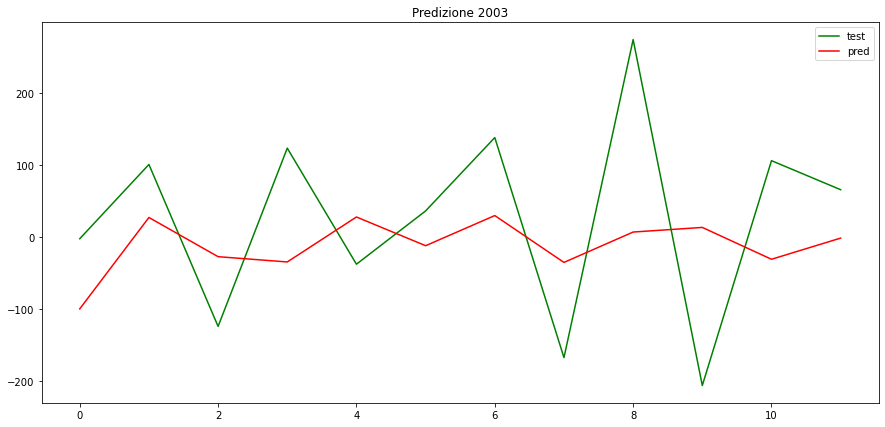

In [79]:
plt.plot(test, label='test', color='green')
plt.plot(pred, label='pred', color='red')
plt.title('Predizione 2003')
plt.legend()
plt.show()

In [80]:
rmse = round(np.sqrt(mean_squared_error(test, pred)), 2)
rmse

138.04

La qualità della predizione è scarsa

Chiaramente predire avanti di 12 mesi sulla base di soli 24 non è ottimale.
Proviamo a predire in maniera sequenziale un periodo alla volta come è stato fatto con ARIMA per valutare se c'è un miglioramento dei risultati.

"Walk-forward validation is the gold standard of model evaluation" [pg 153]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


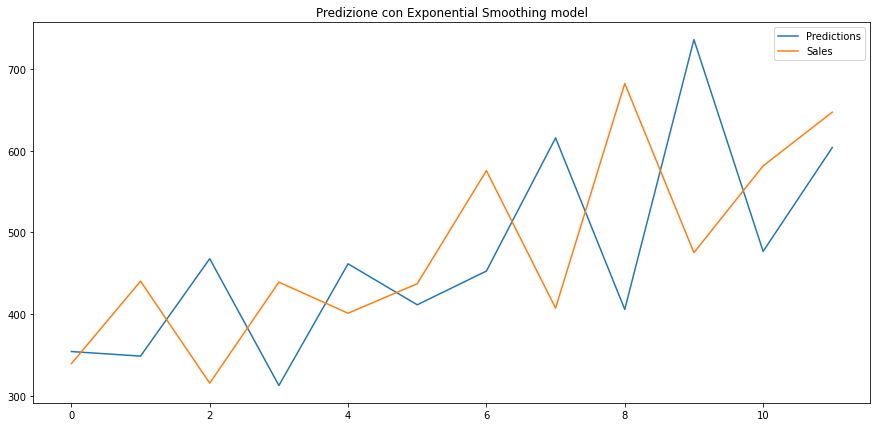

Root mean squared error is: 149.14
R-squared is: -0.77
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA  Delta ARIMA  \
Month                                                                        
2003-01-01  339.7          307.71       311.74         250.32       297.48   
2003-02-01  440.4          323.67       327.86         263.62       350.09   
2003-03-01  315.9          363.79       351.25         279.65       386.93   
2003-04-01  439.3          387.94       382.94         301.03       411.50   
2003-05-01  401.3          361.58       358.55         288.98       363.44   

            Delta AR  Delta MA  Sales SARIMAX  Exp smooth  
Month                                                      
2003-01-01    261.61    348.46         307.52      354.50  
2003-02-01    335.95    367.16         407.19      348.94  
2003-03-01    457.64    402.10         343.51      467.93  
2003-04-01    399.70    409.96         435.57      313.03  
2003-05-01    363.76    392.16        

In [81]:
exp_smooth_prediction(df)

Il miglioramento non è avvenuto, praticamente il modello si limita a predire un valore in linea con quello precedente,
cioè quello che di volta in volta si aggiunge al train, basare scelte strategiche su queste previsioni sarebbe disastroso in questo caso. Praticamente il modello si comporta come un Persistence Forecast model o Naive Forecast: prediction[t+1] = real value[t]

AUTOREGRESSIVE MODEL

In [82]:
model = AutoReg(train, lags=2).fit()

forecasts = model.forecast(12).tolist()
test_values = test.tolist()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


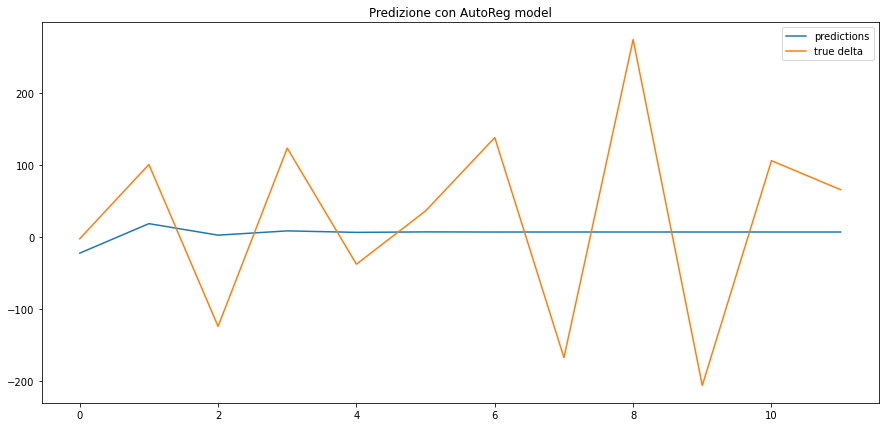

In [83]:
plt.plot(forecasts, label='predictions')
plt.plot(test_values, label='true delta')
plt.title('Predizione con AutoReg model')
plt.legend()
plt.show()

In [84]:
rmse_model = round(np.sqrt(mean_squared_error(test, pred)), 2)
rmse_model

138.04

Predire avanti di 12 mesi sulla base di soli 24 non è ottimale.
Proviamo a predire in maniera sequenziale un periodo alla volta come è stato fatto con ARIMA per valutare se c'è un miglioramento dei risultati.

In [85]:
def auto_reg_model(df: pd.DataFrame) -> None:
    """
    Make sales prediction for year 2003 and shows its plot and calculates rmse

    Parameters
    ----------
    df : Pandas.DataFrame
    input time series: the 'Delta' column is mandatory


    Returns
    -------
    None
    """
    train = df.loc[:'2002', "Delta"].values
    test = df.loc['2003', "Delta"].values
    
    month_bf_sales = df.loc['2002-12':'2003-11', 'Sales'].values
    sales_2003 = df.loc['2003', 'Sales'].values
    
    history = [x for x in train]

    predictions = list()
    for i, t in enumerate(test):
        model = AutoReg(history, lags=2)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]

        predictions.append(round(yhat+month_bf_sales[i], 2))
        history.append(t)
    
    plt.plot(predictions, label='Predictions')
    plt.plot(sales_2003, label='Sales')
    plt.title('Predizione con Auto-regressive model')
    plt.legend()
    plt.show()
    
    rmse = round(np.sqrt(mean_squared_error(sales_2003, predictions)), 2)
    print('Root mean squared error is:', rmse)
    
    r2 = round(r2_score(sales_2003, predictions), 2)
    print('R-squared is:', r2)
    
    df_predictions['Auto reg'] = predictions
    print(df_predictions.head())
    
    model_performance['Auto reg'] = {'rmse': rmse , 'r2': r2}
    print(model_performance)
    
    df_performance.loc[len(df_performance.index)] = ['Auto reg', rmse, r2]
    print(df_performance)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


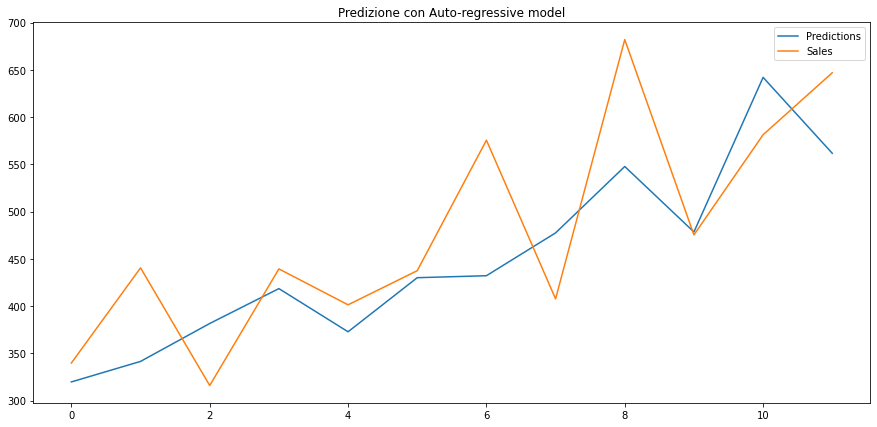

Root mean squared error is: 76.52
R-squared is: 0.54
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA  Delta ARIMA  \
Month                                                                        
2003-01-01  339.7          307.71       311.74         250.32       297.48   
2003-02-01  440.4          323.67       327.86         263.62       350.09   
2003-03-01  315.9          363.79       351.25         279.65       386.93   
2003-04-01  439.3          387.94       382.94         301.03       411.50   
2003-05-01  401.3          361.58       358.55         288.98       363.44   

            Delta AR  Delta MA  Sales SARIMAX  Exp smooth  Auto reg  
Month                                                                
2003-01-01    261.61    348.46         307.52      354.50    319.69  
2003-02-01    335.95    367.16         407.19      348.94    341.40  
2003-03-01    457.64    402.10         343.51      467.93    381.53  
2003-04-01    399.70    409.96         435.57     

In [86]:
auto_reg_model(df)

In questo caso la performance media del modello è aumentata.

In [87]:
def AR_model(df: pd.DataFrame) -> None:
    """
    Make sales prediction for year 2003 and shows its plot and calculates rmse

    Parameters
    ----------
    df : Pandas.DataFrame
    input time series: the 'Delta' column is mandatory


    Returns
    -------
    None
    """
    train = df.loc[:'2002', "Delta"].values
    test = df.loc['2003', "Delta"].values
    
    month_bf_sales = df.loc['2002-12':'2003-11', 'Sales'].values
    sales_2003 = df.loc['2003', 'Sales'].values
    
    history = [x for x in train]

    predictions = list()
    for i, t in enumerate(test):
        model = AR(history)
        model_fit = model.fit()
        output = model_fit.predict()
        yhat = output[0]

        predictions.append(round(yhat+month_bf_sales[i], 2))
        history.append(t)
    
    print('Lag: %s' % model_fit.k_ar)
    
    plt.plot(predictions, label='Predictions')
    plt.plot(sales_2003, label='Sales')
    plt.title('Predizione con AR model auto-laggato')
    plt.legend()
    plt.show()
    
    rmse = round(np.sqrt(mean_squared_error(sales_2003, predictions)), 2)
    print('Root mean squared error is:', rmse)
    
    r2 = round(r2_score(sales_2003, predictions), 2)
    print('R-squared is:', r2)
    
    df_predictions['AR_model'] = predictions
    print(df_predictions.head())
    
    model_performance['AR_model'] = {'rmse': rmse , 'r2': r2}
    print(model_performance)
    
    df_performance.loc[len(df_performance.index)] = ['AR_model', rmse, r2]
    print(df_performance)

Lag: 9


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


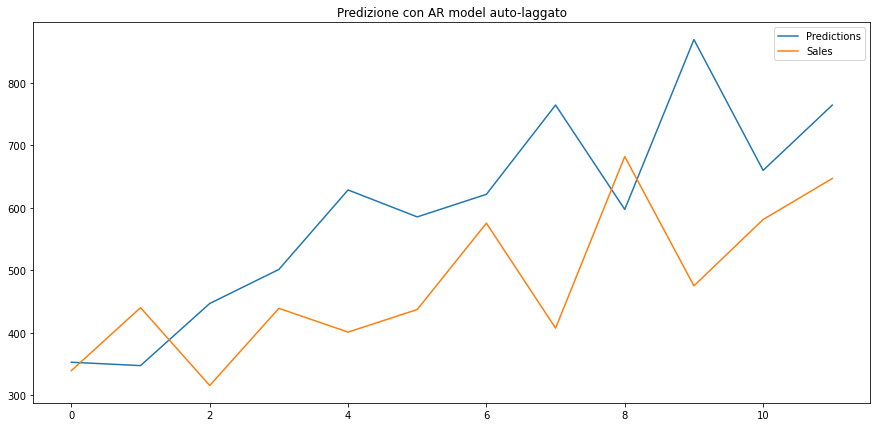

Root mean squared error is: 185.96
R-squared is: -1.75
            Sales  Natural log AR  Sales ARIMA  Box_cox ARIMA  Delta ARIMA  \
Month                                                                        
2003-01-01  339.7          307.71       311.74         250.32       297.48   
2003-02-01  440.4          323.67       327.86         263.62       350.09   
2003-03-01  315.9          363.79       351.25         279.65       386.93   
2003-04-01  439.3          387.94       382.94         301.03       411.50   
2003-05-01  401.3          361.58       358.55         288.98       363.44   

            Delta AR  Delta MA  Sales SARIMAX  Exp smooth  Auto reg  AR_model  
Month                                                                          
2003-01-01    261.61    348.46         307.52      354.50    319.69    353.11  
2003-02-01    335.95    367.16         407.19      348.94    341.40    347.71  
2003-03-01    457.64    402.10         343.51      467.93    381.53    447.05 

In [88]:
AR_model(df)

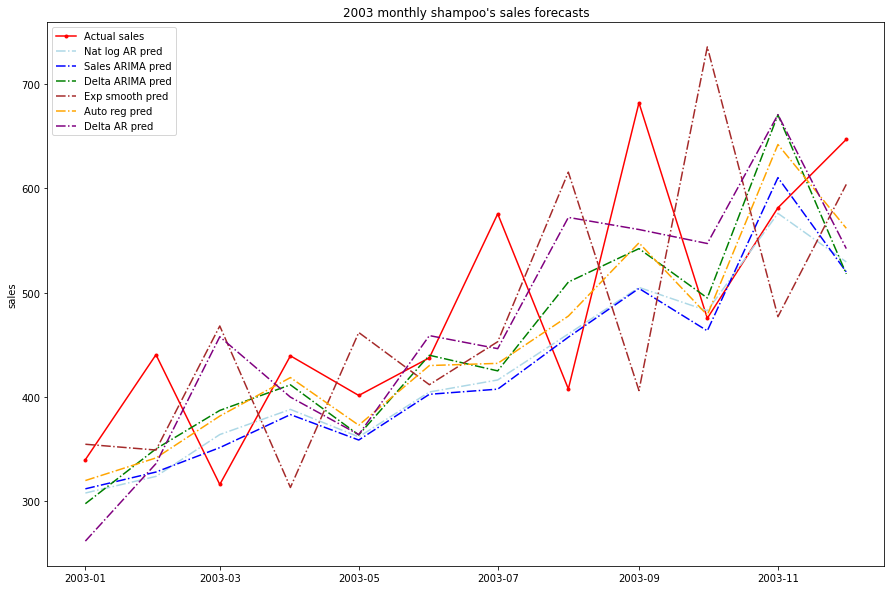

In [89]:
plt.figure(figsize=(15, 10))

plt.plot(df_predictions['Sales'],
         label='Actual sales',
         linestyle='-',
         color='red',
         marker='o',
         markersize=3)
plt.plot(df_predictions['Natural log AR'],
         label='Nat log AR pred',
         linestyle='-.',
         color='lightblue')
plt.plot(df_predictions['Sales ARIMA'],
         label='Sales ARIMA pred',
         linestyle='-.',
         color='blue')
plt.plot(df_predictions['Delta ARIMA'],
         label='Delta ARIMA pred',
         linestyle='-.',
         color='green')
plt.plot(df_predictions['Exp smooth'],
         label='Exp smooth pred',
         linestyle='-.',
         color='brown')
plt.plot(df_predictions['Auto reg'],
         label='Auto reg pred',
         linestyle='-.',
         color='orange')
plt.plot(df_predictions['Delta AR'],
         label='Delta AR pred',
         linestyle='-.',
         color='purple')
plt.ylabel('sales')
plt.legend()
plt.title("2003 monthly shampoo's sales forecasts")
plt.show()

In [90]:
colors = ['red', 'lightblue', 'blue', 'green', 'brown', 'orange', 'purple', 'yellow', 'pink', 'grey', 'violet']
diz_cols = {}
for i, c in enumerate(df_predictions.columns):
    diz_cols[c] = colors[i]
diz_cols

{'Sales': 'red',
 'Natural log AR': 'lightblue',
 'Sales ARIMA': 'blue',
 'Box_cox ARIMA': 'green',
 'Delta ARIMA': 'brown',
 'Delta AR': 'orange',
 'Delta MA': 'purple',
 'Sales SARIMAX': 'yellow',
 'Exp smooth': 'pink',
 'Auto reg': 'grey',
 'AR_model': 'violet'}

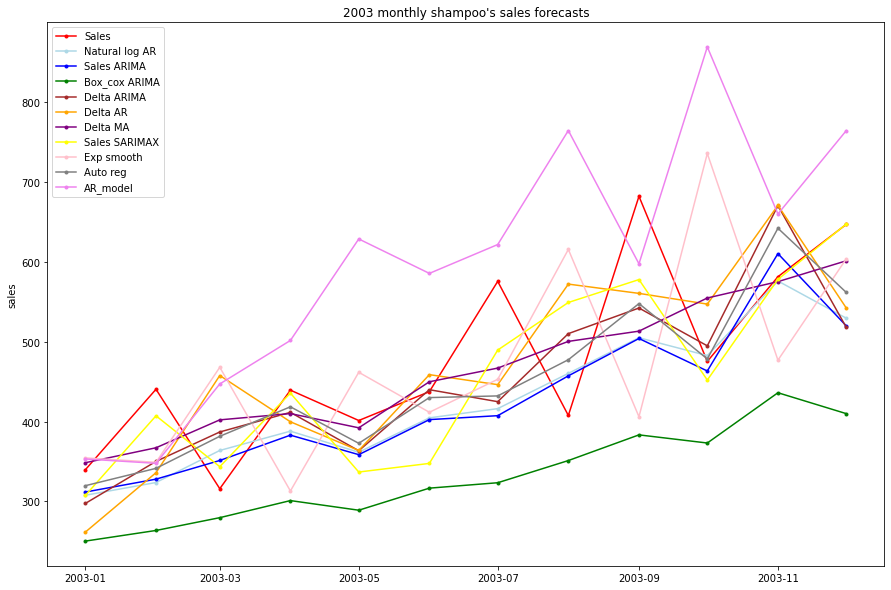

In [91]:
plt.figure(figsize=(15, 10))
for k in diz_cols.keys():
    plt.plot(df_predictions[k],
             label=k,
             linestyle='-',
             color=diz_cols[k],
             marker='o',
             markersize=3)
plt.ylabel('sales')
plt.legend()
plt.title("2003 monthly shampoo's sales forecasts")
plt.show()

In [92]:
rmse_avg = df_performance['Rmse'].mean()
rmse_avg

109.277

ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

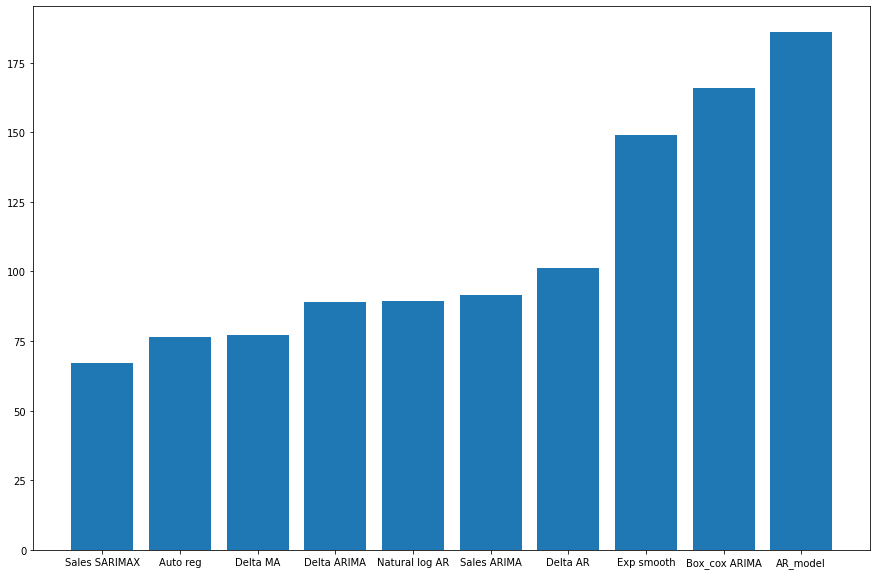

In [93]:
rmse_avg_list = [rmse_avg] * 9
df_perf_sorted = df_performance.sort_values('Rmse')
plt.figure(figsize=(15, 10))
plt.bar(df_perf_sorted['Model'],
        df_perf_sorted['Rmse'])
plt.plot(df_perf_sorted['Model'], rmse_avg_list, linestyle='-',
         label='Average rmse',
         color='red'
         )
plt.title('Root Mean Squared Error model comparison')
plt.legend()
plt.show()


Il modello migliore in termini di Rmse è quello ARIMA che sfrutta i dati differenziati della colonna Delta,
seguito dal modello ottenuto con la classe AutoReg.

In [ ]:
df_perf_sorted = df_performance.sort_values('R2')
plt.figure(figsize=(15, 10))
plt.bar(df_perf_sorted['Model'],
        df_perf_sorted['R2'])
plt.title('R squared model comparison')

Anche in termini di R2 ovviamente i migliori sono Auto reg e Delta ARIMA.

Proviamo a usare il modello Prophet ideato da Facebook

In [ ]:
df_train_prophet = df.loc[:'2003-06', 'Sales'].reset_index()
df_train_prophet.columns = ['ds', 'y']
df_train_prophet.tail()

In [ ]:
df_test = df.loc['2003-07':]
df_test

In [ ]:
df_train_prophet.shape

In [ ]:
model = Prophet()
model.fit(df_train_prophet);

In [ ]:
future = model.make_future_dataframe(periods=6, freq='MS', include_history=False)
future

In [ ]:
test_predictions = model.predict(future)

In [ ]:
test_predictions[['ds','yhat']]

In [ ]:
df_test['Prediction'] = test_predictions['yhat'].values
df_test

In [ ]:
plt.figure(figsize=(25, 7))

plt.plot(df_test['Sales'],
         linestyle='-',
         color='black',
         linewidth=1,
         label='observed')

plt.plot(df_test['Prediction'],
         linestyle='-',
         linewidth=1,
         color='orange',
         label='predicted')

plt.title('2003 - Sales')
plt.legend();

Scarsa capacità predittiva